# Compare followers' interests: What do they tweet about?

In [12]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [13]:
target_1 = config.target_user
target_2 = config.target_user2
target_month = config.target_month

In [14]:
tweets_dir_1 = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target_1)
tweets_dir_2 = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target_2)

english_file_1 = '/'.join([tweets_dir_1, target_month  + '_english.csv'])
french_file_1 = '/'.join([tweets_dir_1, target_month  + '_french.csv'])
german_file_1 = '/'.join([tweets_dir_1, target_month  + '_german.csv'])
english_file_2 = '/'.join([tweets_dir_2, target_month  + '_english.csv'])
french_file_2 = '/'.join([tweets_dir_2, target_month  + '_french.csv'])
german_file_2 = '/'.join([tweets_dir_2, target_month  + '_german.csv'])


## Tweets: English

In [15]:
def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))

stopwords_nltk = set(stopwords.words("english"))
#relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [16]:
tweets_english_1 = pd.read_csv(english_file_1, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

tweets_english_1['text_wo_#'] = tweets_english_1['text_processed'].apply(lambda x: remove_hash(x))
#tweets_english_1['text_wo_#@'] = tweets_english_1['text_wo_#'].apply(lambda x: remove_at(x))

#X_train_en_1 = tweets_english_1['text_wo_#@'].apply(lambda x: ' '.join(x))
X_train_en_1 = tweets_english_1['text_wo_#'].apply(lambda x: ' '.join(x))

In [17]:
tweets_english_2 = pd.read_csv(english_file_2, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
  
tweets_english_2['text_wo_#'] = tweets_english_2['text_processed'].apply(lambda x: remove_hash(x))
#tweets_english_2['text_wo_#@'] = tweets_english_2['text_wo_#'].apply(lambda x: remove_at(x))

#X_train_en_2 = tweets_english_2['text_wo_#@'].apply(lambda x: ' '.join(x))
X_train_en_2 = tweets_english_2['text_wo_#'].apply(lambda x: ' '.join(x))

In [18]:
vectorizer_1 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_1 = vectorizer_1.fit_transform(X_train_en_1)
feature_names_1 = vectorizer_1.get_feature_names()

In [19]:
vectorizer_2 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_2 = vectorizer_2.fit_transform(X_train_en_2)
feature_names_2 = vectorizer_2.get_feature_names()

In [20]:
lda_models = {'target_1': [], 'target_2': []}

for word_matrix in [word_matrix_1, word_matrix_2]:
    for n_topics in range(1,4):    
        lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
        lda.fit(word_matrix)
        if id(word_matrix) == id(word_matrix_1):
            lda_models['target_1'].append(lda)
        else:
            lda_models['target_2'].append(lda)

/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value

In [21]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words, feature_names):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Target 1 most important words:

Topic #0:
703.7: oracle
491.8: cloud
472.2: @lukaseder
406.5: new
361.6: 12.2
333.6: @sfonplsql
322.1: data
309.1: like
308.7: database
306.4: great
283.7: get
280.0: thanks
278.7: trump
278.2: sql
273.2: bigdata
264.0: it's
259.5: see
247.8: way
244.4: time
243.1: @talend

Target 2 most important words:

Topic #0:
1139.8: oracle
889.6: cloud
861.9: @developerworks
639.2: new
580.4: data
449.6: ~
445.8: ibm
389.3: database
384.3: sql
359.5: learn
349.9: azure
307.4: @sfonplsql
306.5: 12.2
296.9: https
293.2: @datavail
287.5: @oraclehardware
285.6: trump
285.2: iot
284.9: get
283.2: see



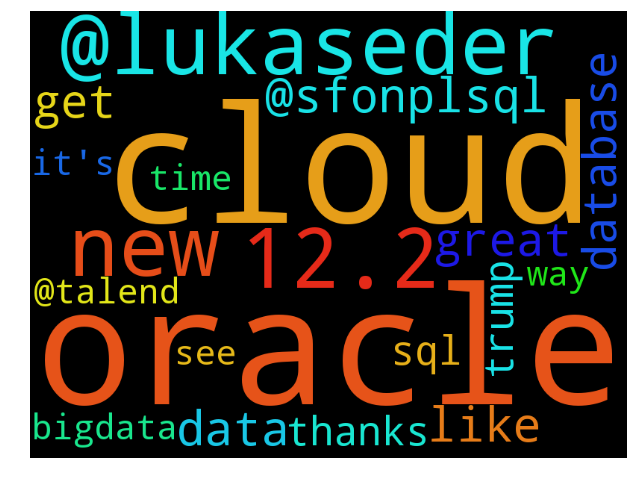

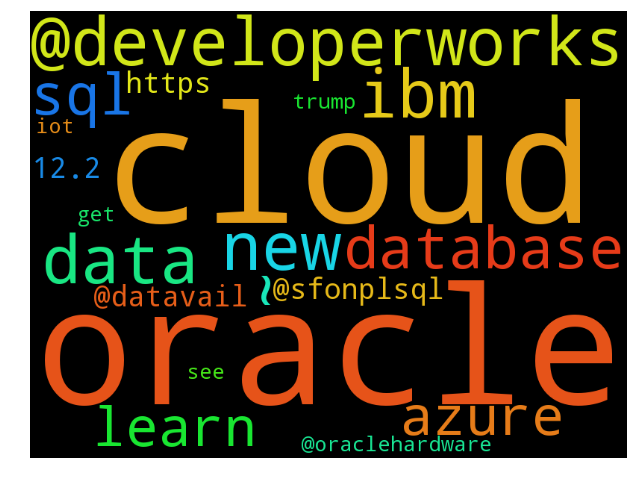

In [23]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'], [lda_models['target_1'][0], lda_models['target_2'][0]],
                           [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)
    fig, ax1 = plt.subplots(figsize = (12, 8))
    axes = [ax1]
    show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Target 1 most important words:

Topic #0:
405.3: cloud
278.0: trump
231.0: great
216.4: see
215.6: free
198.0: @oracleace
196.9: iot
192.5: oracle
190.0: thanks
188.1: data
183.3: new
179.6: tower
178.2: @exagriddba
167.7: day
165.9: next
163.3: good
162.8: 2
161.4: street
159.1: entrance
158.2: 56th

Topic #1:
511.2: oracle
471.6: @lukaseder
361.0: 12.2
329.5: @sfonplsql
307.9: database
277.5: sql
271.7: like
245.7: way
223.2: new
222.7: make
188.1: @franckpachot
179.2: :)
172.5: get
163.2: @oracledatabase
161.2: devoxx
151.9: lazy
151.2: learn
149.3: bigdata
141.4: available
135.0: it's

Target 2 most important words:

Topic #0:
331.5: @developerworks
306.8: @sfonplsql
299.3: new
285.1: trump
227.8: ibm
216.2: video
211.9: blockchain
208.4: ~
188.3: like
181.7: one
181.2: great
179.0: help
177.6: tower
176.7: @exagriddba
175.0: get
171.5: guide
169.7: developers
162.3: street
156.6: locked
156.6: https://t.co/xr1hfvxmqv

Topic #1:
1130.2: oracle
802.2: cloud
579.7: data
530.4: @devel

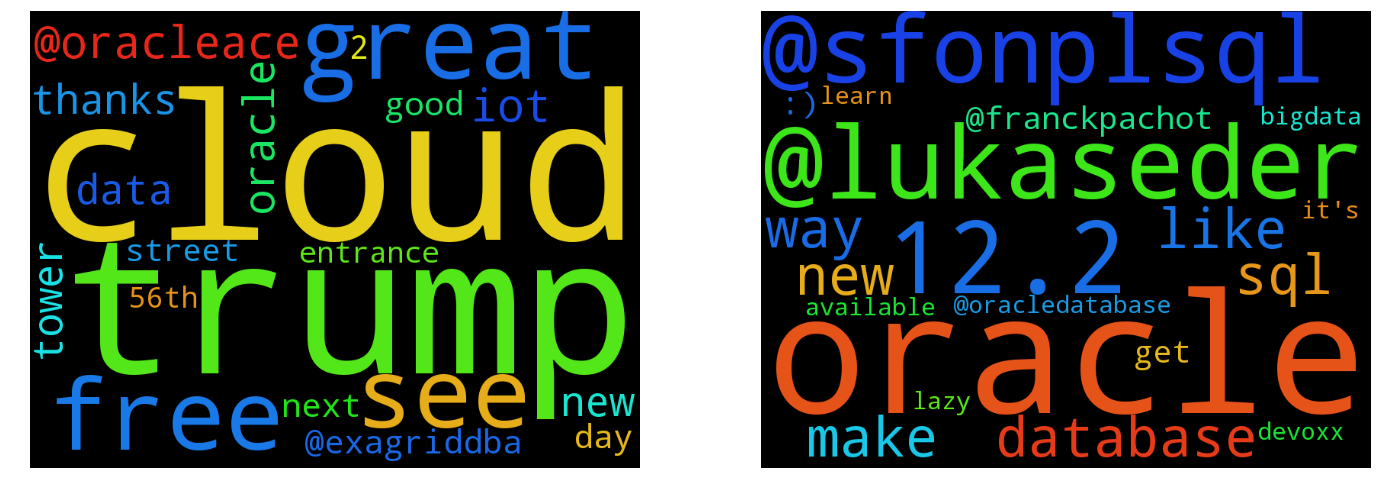

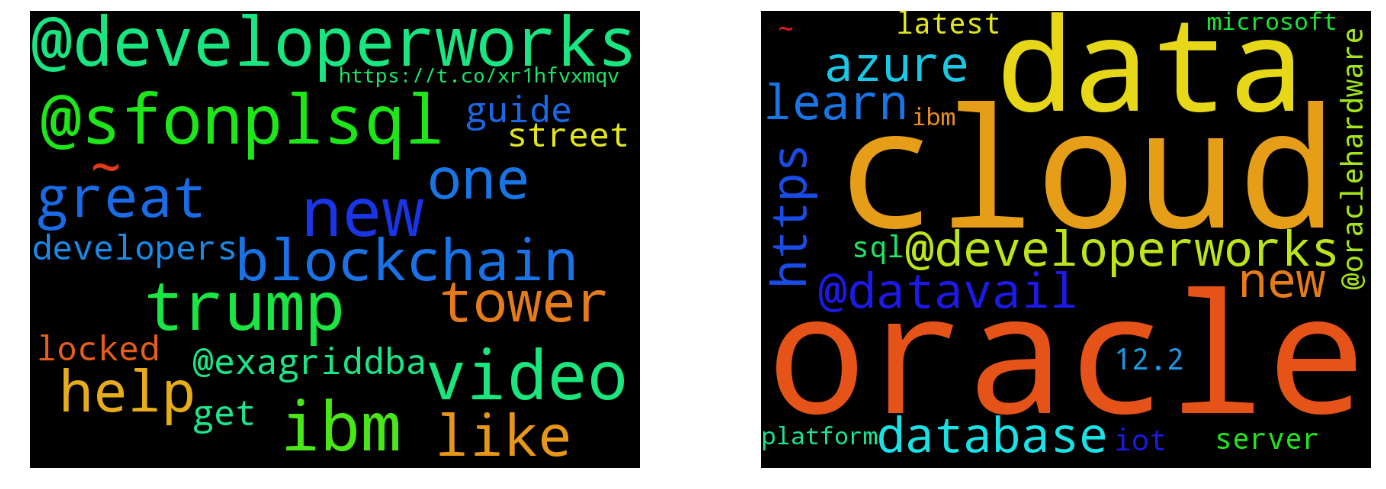

In [26]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'], [lda_models['target_1'][1], lda_models['target_2'][1]],
                           [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
    axes = [ax1, ax2]
    show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Target 1 most important words:

Topic #0:
481.7: cloud
258.6: see
237.6: great
232.5: new
226.2: oracle
215.2: free
197.9: @oracleace
196.5: iot
165.5: good
159.5: thanks
155.5: @oracle
141.8: still
140.9: doag2016
138.7: @oraclesk
134.3: data
131.0: day
128.7: :-)
124.9: 5
118.3: features
118.1: sangam16

Topic #1:
477.1: oracle
300.2: database
299.6: @lukaseder
272.8: sql
271.8: 12.2
231.7: like
229.2: @sfonplsql
173.4: new
141.4: available
139.9: @oracledatabase
131.9: plsql
119.2: really
117.9: retweet
115.0: video
108.0: thanks
105.9: interesting
105.4: pl
103.0: well
96.6: world
96.3: @mikedietrichde

Topic #2:
282.6: get
278.0: trump
240.5: :)
220.9: learn
210.3: way
195.8: don't
191.0: make
188.7: @msftcitynext
179.4: tower
178.1: @exagriddba
172.2: @lukaseder
167.7: it's
162.8: data
161.2: street
158.9: entrance
158.0: residential
158.0: 56th
158.0: locked
158.0: https://t.co/xr1hfvxmqv
151.2: lazy

Target 2 most important words:

Topic #0:
367.9: oracle
293.4: new
284.8: trum

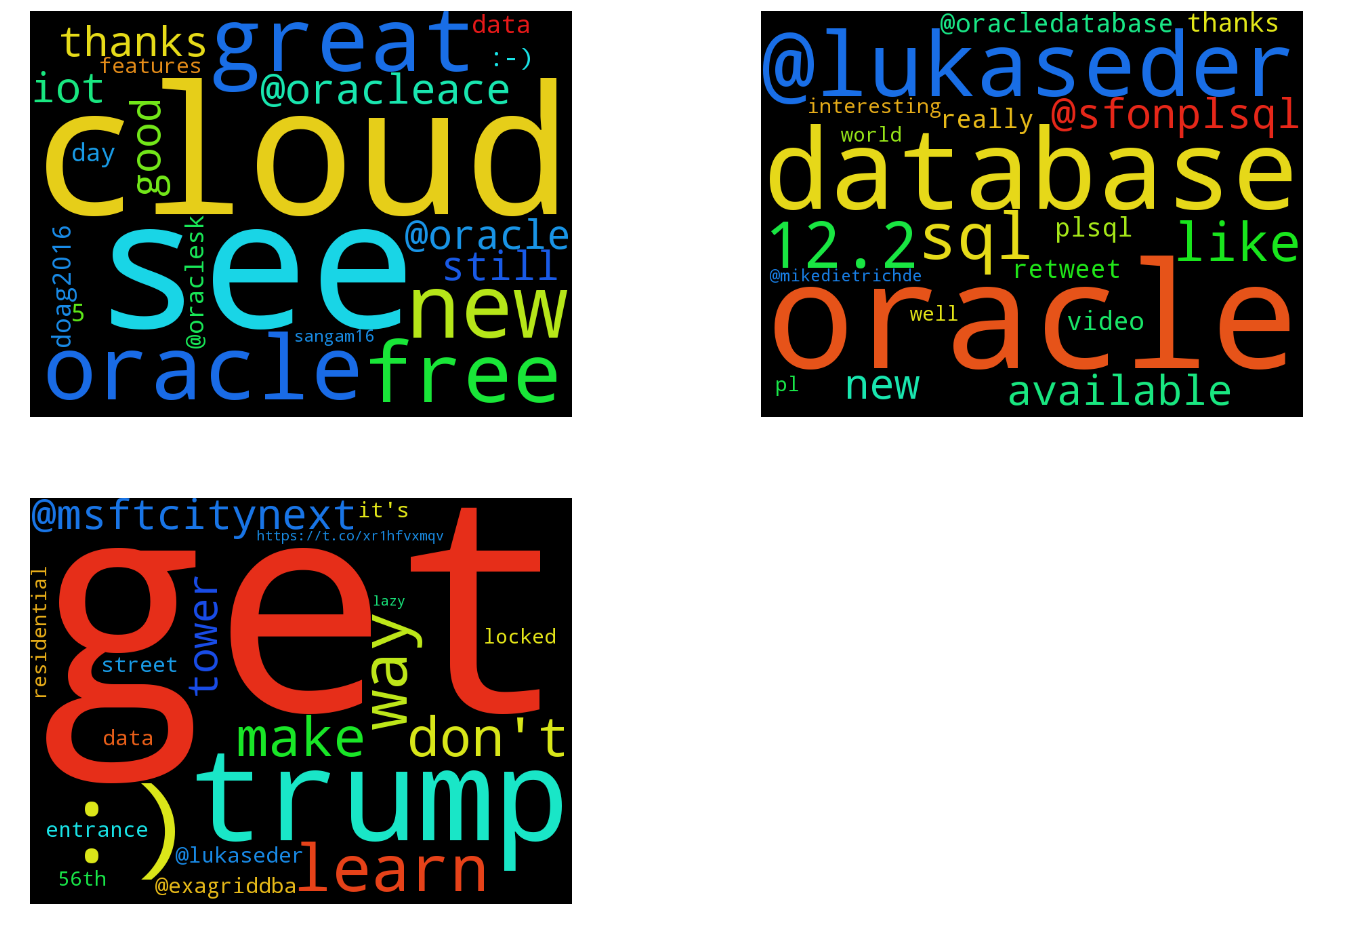

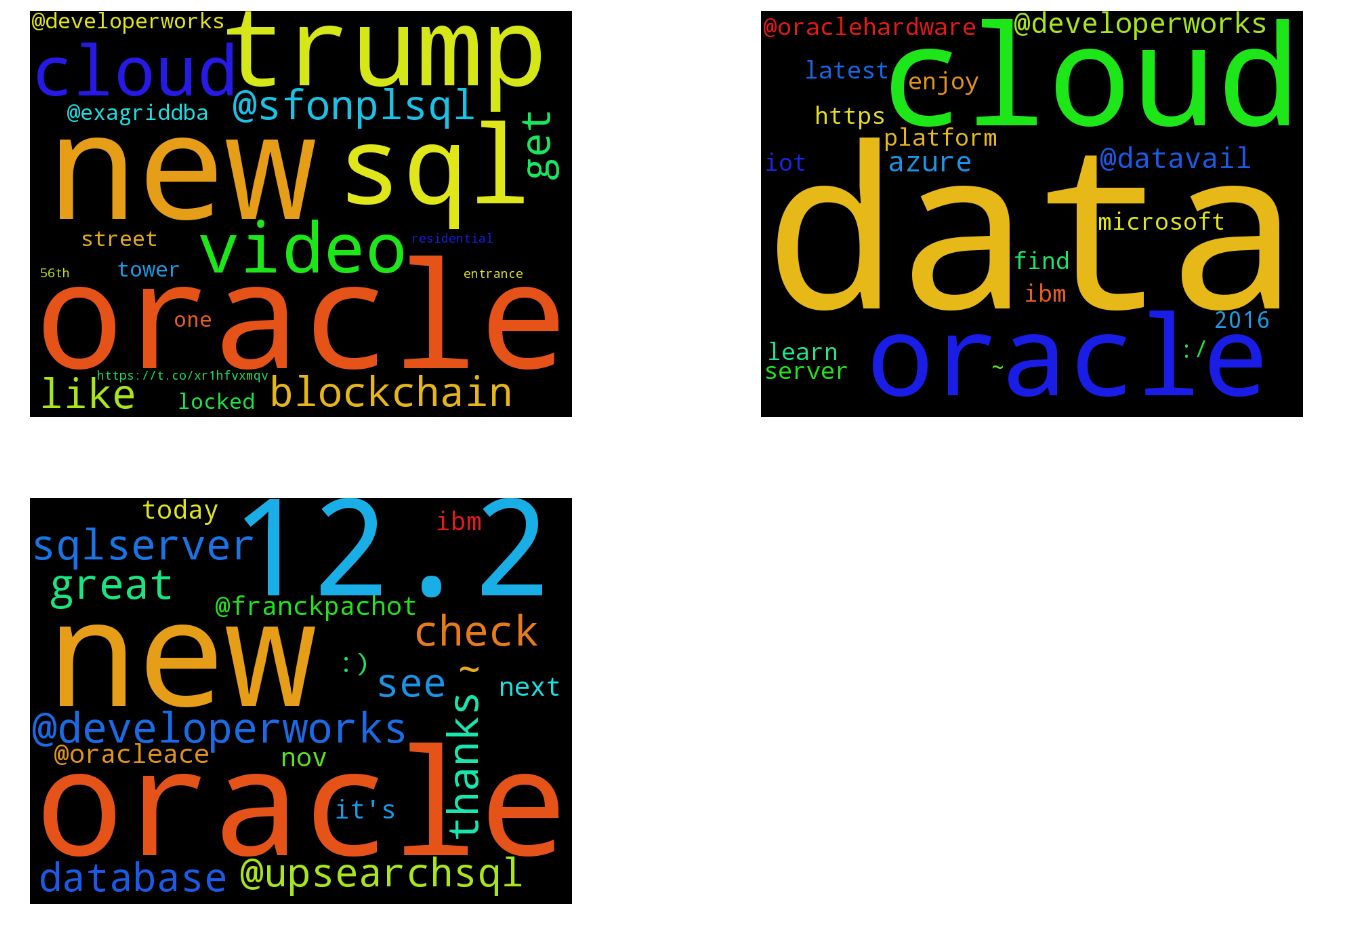

In [27]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'],
                                          [lda_models['target_1'][2], lda_models['target_2'][2]],
                                          [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
    axes = [ax1, ax2, ax3]
    show_word_clouds(model, axes, n_top_words)
    ax4.axis('off')

## Which words do often occur together?

In [28]:
vectorizer_1 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_1 = vectorizer_1.fit_transform(X_train_en_1)

co_occurrence_matrix_1 = word_matrix_1.T * word_matrix_1
co_occurrence_matrix_1.setdiag(0) 
array_1 = co_occurrence_matrix_1.toarray()
co_occurrences_1 = pd.DataFrame(array_1)
#co_occurrences.shape

In [29]:
vectorizer_2 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_2 = vectorizer_2.fit_transform(X_train_en_2)

co_occurrence_matrix_2 = word_matrix_2.T * word_matrix_2
co_occurrence_matrix_2.setdiag(0) 
array_2 = co_occurrence_matrix_2.toarray()
co_occurrences_2 = pd.DataFrame(array_2)
#co_occurrences.shape

In [30]:
vocab = vectorizer_1.get_feature_names()
co_occurrences_1['word'] = vocab
co_occurrences_1 = co_occurrences_1.set_index('word')
co_occurrences_1.columns = vocab
#co_occurrences.head()

In [31]:
vocab = vectorizer_2.get_feature_names()
co_occurrences_2['word'] = vocab
co_occurrences_2 = co_occurrences_2.set_index('word')
co_occurrences_2.columns = vocab
#co_occurrences.head()

In [18]:
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    sorted = coocs.sort_values(ascending = False)
    return sorted[:n]

def plot_co_occurrences(word, coocs, colors):
    plt.figure(figsize = (12, 8))
    plt.ylabel('number of co-occurrences')
    plt.title('Co-occurrences for: {}'.format(word))
    coocs.plot(kind='bar', color = colors, alpha = 1)
    plt.show()



Target: Target 1

Co-occurrences for: oracle
database     123
cloud        106
new           63
data          62
2016          60
available     44
october       41
12c           37
patch         31
12.2          31
service       29
psu           28
Name: oracle, dtype: int64




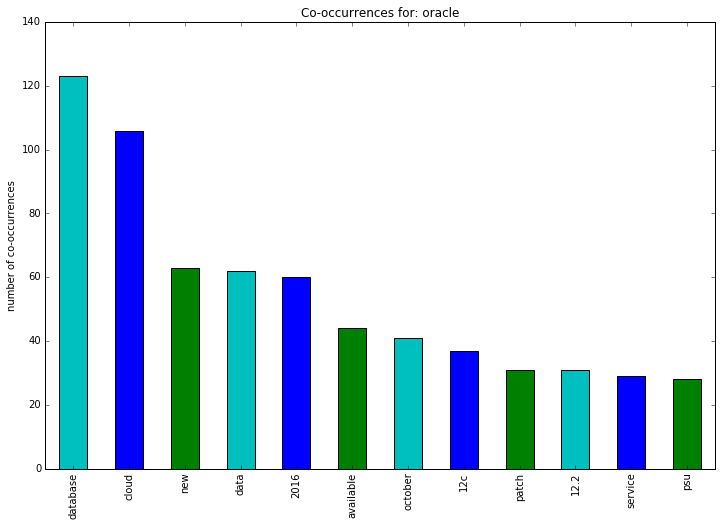


Target: Target 2

Co-occurrences for: oracle
cloud              258
database           123
new                106
bi                  97
data                92
2016                63
@datavail           61
services            61
blog                56
@oraclehardware     54
appliance           54
analytics           40
Name: oracle, dtype: int64




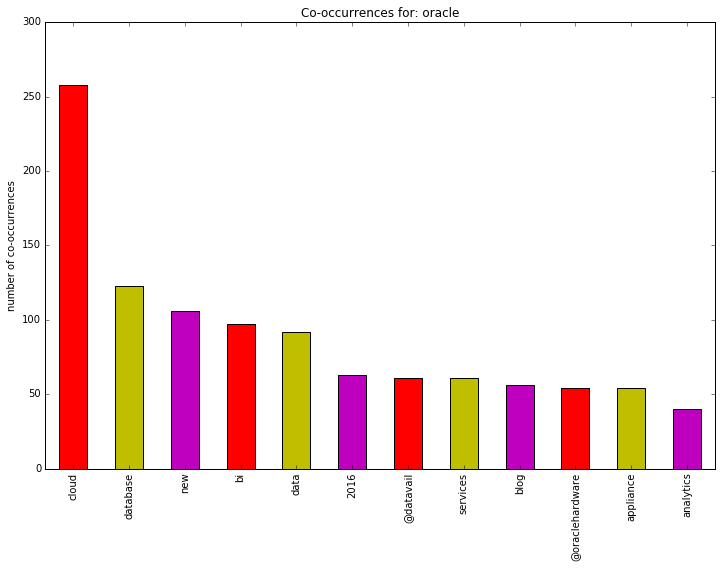


Target: Target 1

Co-occurrences for: microsoft
iamcp        38
partners     31
city         30
10           24
event        23
windows      22
solutions    16
launch       16
smart        15
safer        15
expo         15
present      15
Name: microsoft, dtype: int64




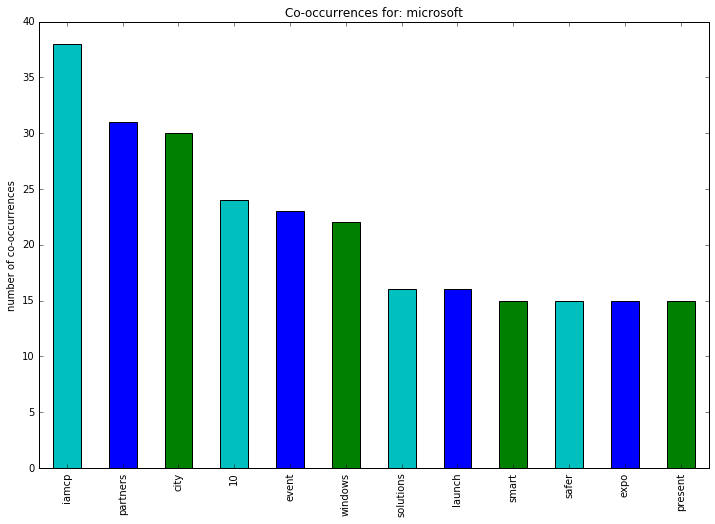


Target: Target 2

Co-occurrences for: microsoft
cloud            88
@evankirstel     84
new              46
@microsoftiot    43
makers           43
starter          43
kits             43
announce         43
iot              43
updated          43
azure            35
google           33
Name: microsoft, dtype: int64




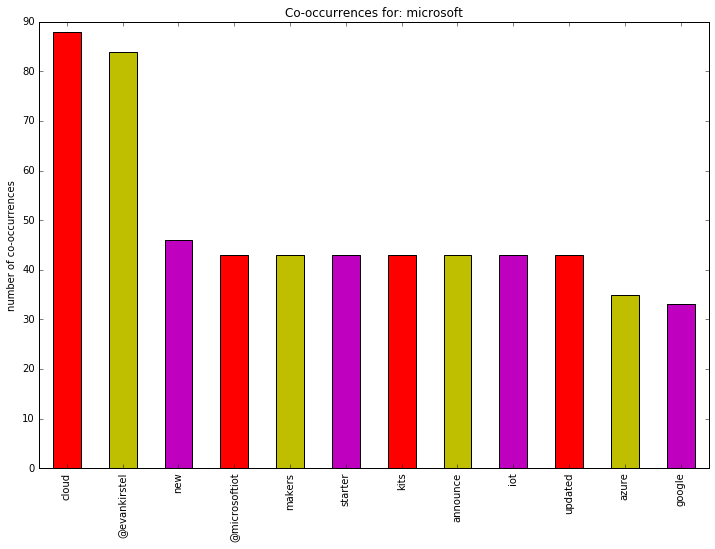


Target: Target 1

Co-occurrences for: iot
bigdata            14
@talend            13
get                12
new                11
@drnatalie          9
things              9
cloud               9
learn               8
customers           8
machinelearning     8
instant             7
data                7
Name: iot, dtype: int64




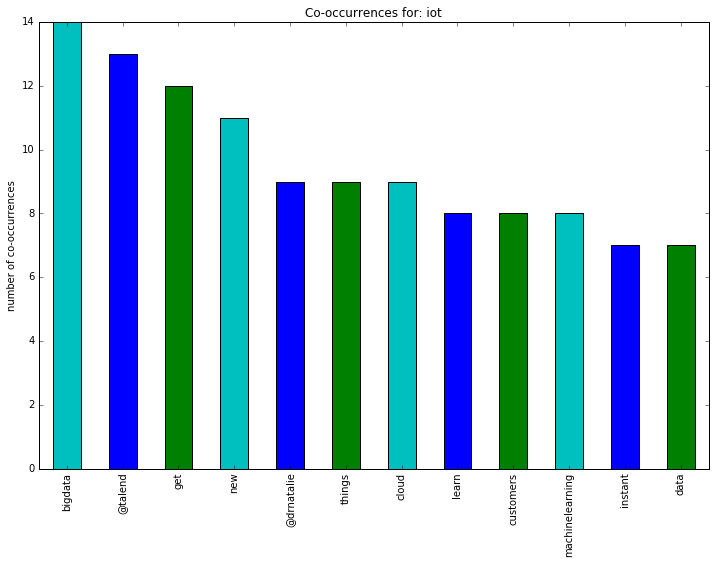


Target: Target 2

Co-occurrences for: iot
@evankirstel     1340
dellemcworld      353
internet          265
things            219
|                 182
https             176
bigdata           174
cloud             173
new               156
iiot              155
cybersecurity     141
m2m               124
Name: iot, dtype: int64




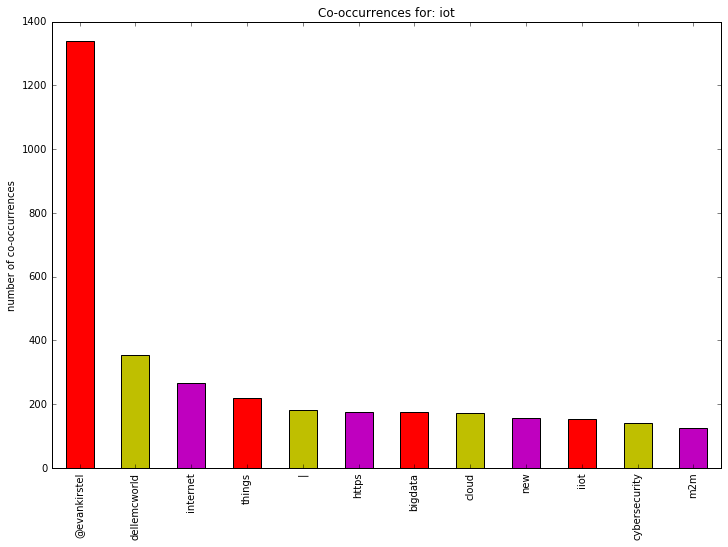


Target: Target 1

Co-occurrences for: bigdata
@talend            71
hadoop             63
analytics          40
data               37
machinelearning    27
datascience        27
talend             22
new                18
powered            17
berlin             17
strategy           16
ai                 15
Name: bigdata, dtype: int64




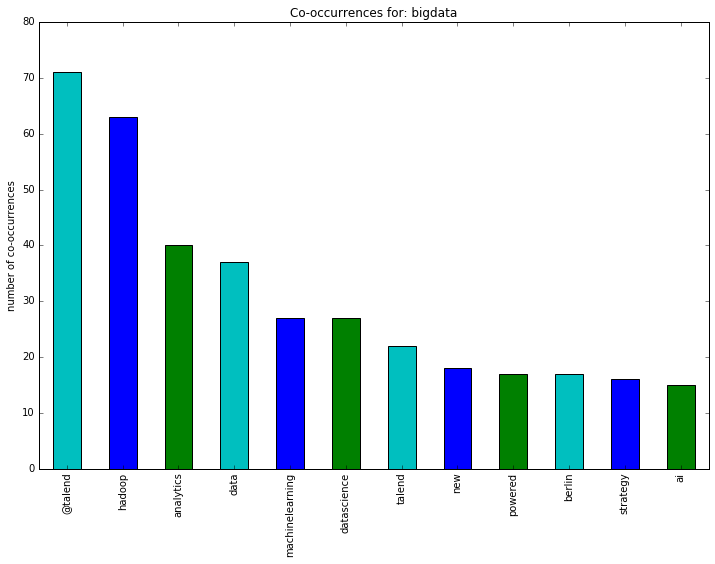


Target: Target 2

Co-occurrences for: bigdata
analytics         192
iot               174
@evankirstel      142
@eric_kavanagh    117
data               99
hottech16          54
dellemcworld       51
big                45
|                  41
business           40
@cloudexpo         38
future             38
Name: bigdata, dtype: int64




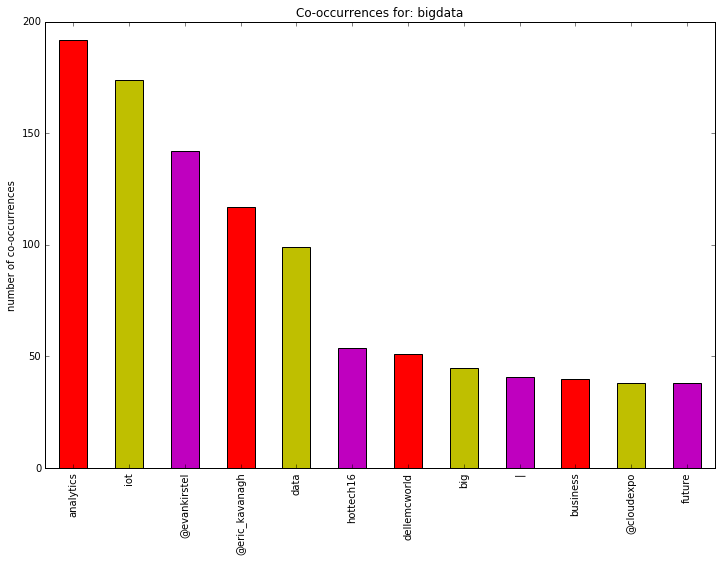


Target: Target 1

Co-occurrences for: cloud
oracle             106
@oracle             53
@oraclepartners     50
service             45
new                 33
data                30
move                30
services            24
free                23
help                21
learning            19
profit              19
Name: cloud, dtype: int64




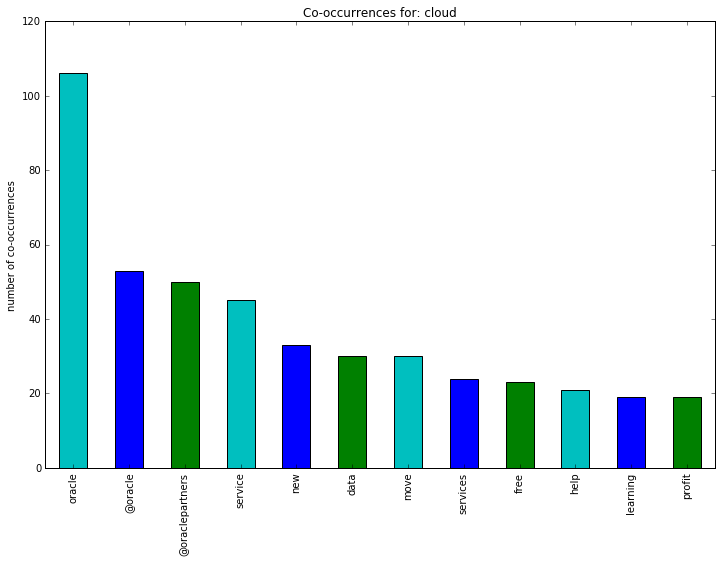


Target: Target 2

Co-occurrences for: cloud
@evankirstel       305
oracle             258
network            181
iot                173
ibm                167
@developerworks    163
build              140
global             131
secure             127
always-on          117
leverage           117
delivery           117
Name: cloud, dtype: int64




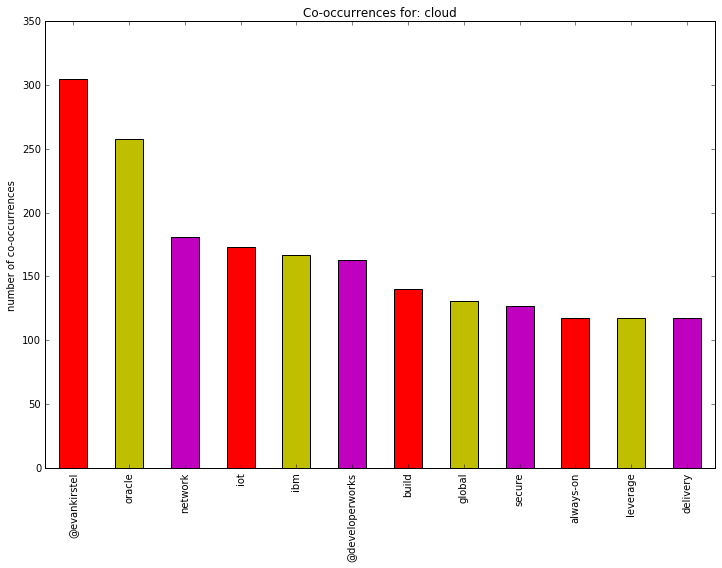


Target: Target 1

Co-occurrences for: machinelearning
bigdata                    27
datascience                26
ai                         18
@gp_pulipaka               12
hadoop                     11
@talend                    11
talend                      8
easy                        8
iot                         8
made                        8
https://t.co/ogbrlsfnkl     5
fast                        5
Name: machinelearning, dtype: int64




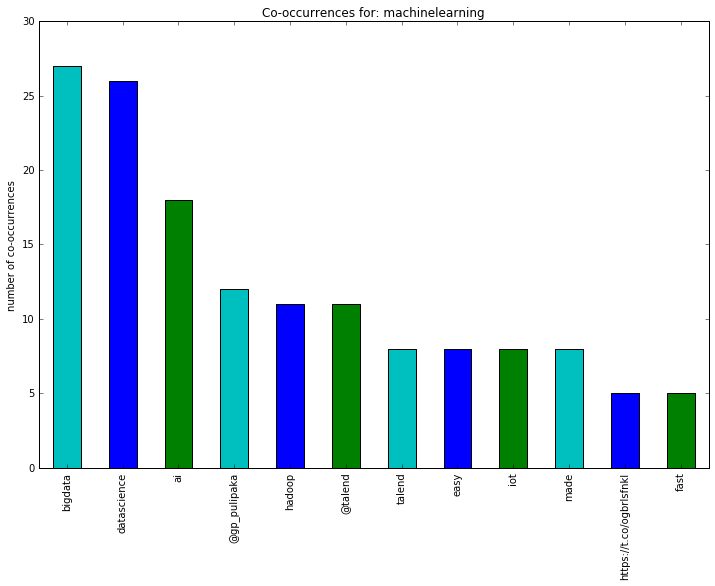


Target: Target 2

Co-occurrences for: machinelearning
ai                         5
opensource                 4
helicalinsight             4
deeplearning               3
➤                          3
nlp                        3
artificialintelligence     3
https://t.co/xicjl7ckog    3
learns                     3
outcomes                   3
@aneeshnair                3
cio                        3
Name: machinelearning, dtype: int64




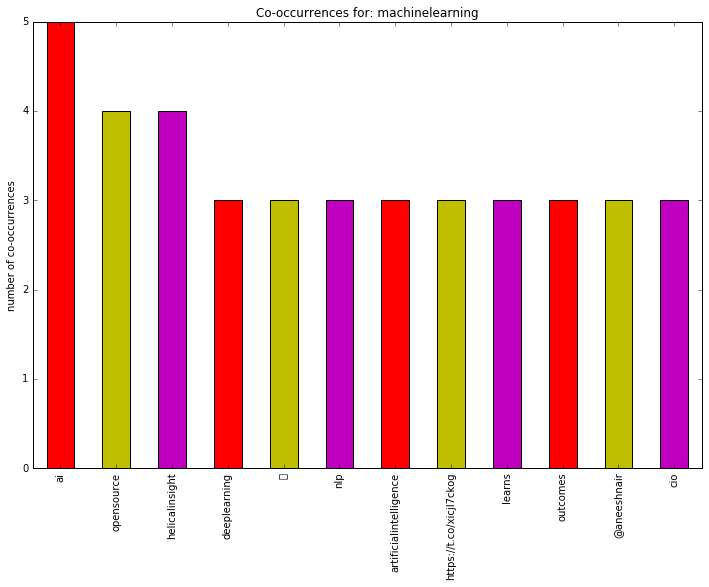

In [19]:
 
words = ['oracle', 'microsoft', 'iot', 'bigdata', 'cloud', 'machinelearning'] 
n = 12
for w in words: 
    for (target, co_occurrences, colors) in zip(['Target 1', 'Target 2'], [co_occurrences_1, co_occurrences_2], ['cbg', 'rym']):

        coocs = get_co_occurrences(co_occurrences, w, n)
        print('\nTarget: {}\n\nCo-occurrences for: {}\n{}\n\n'.format(target, w, coocs))
        plot_co_occurrences(w, coocs, colors)

# Tweets: German

In [20]:
stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
#relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])
relevant_words = set()
additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [21]:
tweets_german_1 = pd.read_csv(german_file_1, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

tweets_german_1['text_wo_#'] = tweets_german_1['text_processed'].apply(lambda x: remove_hash(x))
X_train_de_1 = tweets_german_1['text_wo_#'].apply(lambda x: ' '.join(x))

In [22]:
tweets_german_2 = pd.read_csv(german_file_2, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

tweets_german_2['text_wo_#'] = tweets_german_2['text_processed'].apply(lambda x: remove_hash(x))
X_train_de_2 = tweets_german_2['text_wo_#'].apply(lambda x: ' '.join(x))

In [23]:
X_train_de_1[-10:]

2355      @berndmuller Zum Trost Die guten Bilder werden auf der Web-Site vom Java Forum Nord zu sehen sein
2356    @INFOGRAZ Endlich 4 Alben von Most Jazz https://t.co/1wq6MDm8k5 und lange Nacht der Museen https...
2357                                                      Bauernopfer Risikomanager https://t.co/mWwSchu99m
2358    @BASTAcon Nur noch knapp 2 Wochen bis zu 970 € sparen und zudem einen Workshop Tag ein Tablet fo...
2359                          Was Mitarbeiter tatsächlich wollen https://t.co/Vd4dUtqzLN EmployeeEngagement
2360    Liebe Timeline ich freue mich wie Bolle wenn xpiratar was wird aber ich kann kein Isländisch bit...
2361    @JustynaGrund Clinique Prep Pep Go Event Oder einfach pep-start Das sind die neuen Produkte http...
2362    @DOAGeV Neuer DOAGTermin 18.11 2016 Regionaltreffen Rhein-Main APEX Meetup APEX Meetup https://t...
2363                                                             @INFOGRAZ Danke fuers Follow Es freut mich
2364    SBB der neue Fahrpla

In [24]:
vectorizer_1 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_1 = vectorizer_1.fit_transform(X_train_de_1)
feature_names_1 = vectorizer_1.get_feature_names()

In [25]:
vectorizer_2 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_2 = vectorizer_2.fit_transform(X_train_de_2)
feature_names_2 = vectorizer_2.get_feature_names()

In [26]:
lda_models = {'target_1': [], 'target_2': []}

for word_matrix in [word_matrix_1, word_matrix_2]:
    for n_topics in range(1,4):    
        lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
        lda.fit(word_matrix)
        if id(word_matrix) == id(word_matrix_1):
            lda_models['target_1'].append(lda)
        else:
            lda_models['target_2'].append(lda)

## Most dominating topics - overall - German

Target 1 most important words:

Topic #0:
151.2: @msenterprisede
103.1: @javaforumnord
103.0: mscloudde
102.2: deutsche
99.4: https://t…
94.2: danke
93.5: sicherheit
90.7: msft
89.5: setzt
86.9: sicherheitszertifikat
86.9: d-trust
86.9: germany
86.9: made
75.6: 2016
73.3: jfn16
72.8: mehr
71.3: cloud
68.1: heute
66.7: itawards
59.7: ab

Target 2 most important words:

Topic #0:
102.7: innovationateverylevel
95.9: @it_connection
86.4: it
59.7: cloud
45.0: unternehmen
43.4: 2016
33.8: meetup
30.7: datacenter
30.0: @schneiderelecde
29.9: security
29.7: https://t.co/sqraipeie8
28.5: apex
25.5: oracle
21.0: webcast
20.3: mehr
19.7: neue
18.7: doag2016
18.5: @doagev
18.4: iot
18.3: https://t.co/auqmreb9od



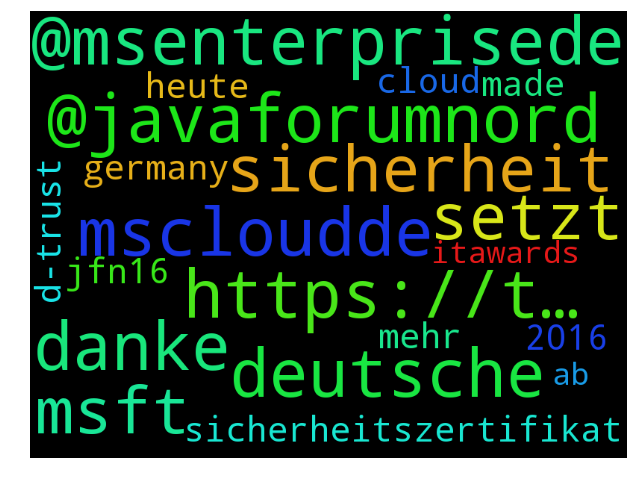

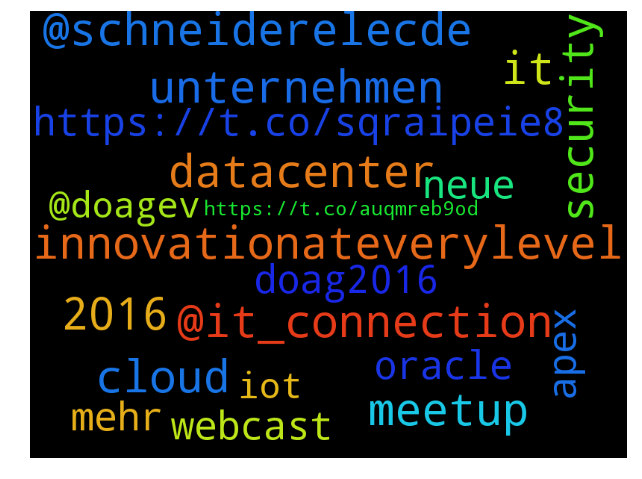

In [27]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'], [lda_models['target_1'][0], lda_models['target_2'][0]],
                           [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)
    fig, ax1 = plt.subplots(figsize = (12, 8))
    axes = [ax1]
    show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - German

Target 1 most important words:

Topic #0:
72.1: jfn16
62.1: 2016
57.8: neue
54.8: java
53.1: ab
50.8: cloud
49.5: itawards
49.2: @javaforumnord
46.2: 4
43.6: oracle
43.3: heute
43.0: digitalisierung
39.8: @doagev
39.3: meetup
39.3: https
37.9: forum
36.7: 2
36.4: bigdata
36.3: neues
36.0: nacht

Topic #1:
147.7: @msenterprisede
102.3: mscloudde
101.7: deutsche
98.8: https://t…
93.0: sicherheit
90.2: msft
89.0: setzt
87.7: danke
86.4: made
86.4: germany
86.4: d-trust
86.4: sicherheitszertifikat
53.8: @javaforumnord
52.5: “
47.3: mehr
43.7: „
40.1: gibt
36.0: geht
35.1: schon
34.7: wer

Target 2 most important words:

Topic #0:
85.3: @it_connection
83.0: it
53.9: cloud
44.2: unternehmen
29.2: https://t.co/sqraipeie8
28.7: security
22.5: 2016
20.4: webcast
17.8: https://t.co/auqmreb9od
16.0: immer
15.4: warum
15.0: netzwerk
14.8: uhr
14.7: deutschland
14.1: kampagnen
13.8: https://t.co/bcz8klxwav
13.0: neue
13.0: heute
12.8: s
12.7: “

Topic #1:
101.6: innovationateverylevel
31.6: meetup


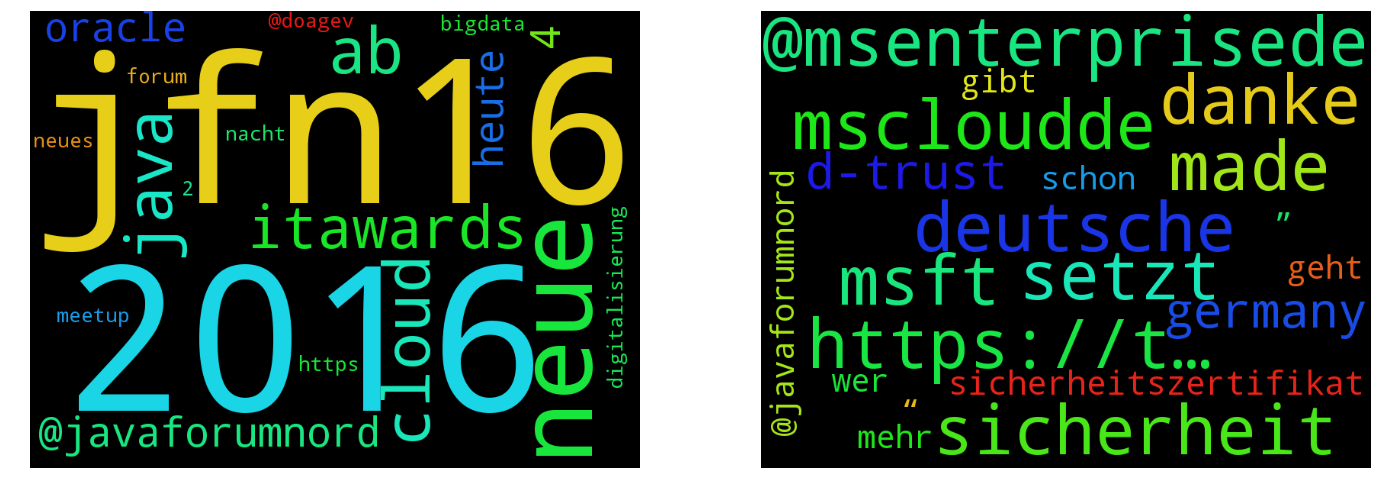

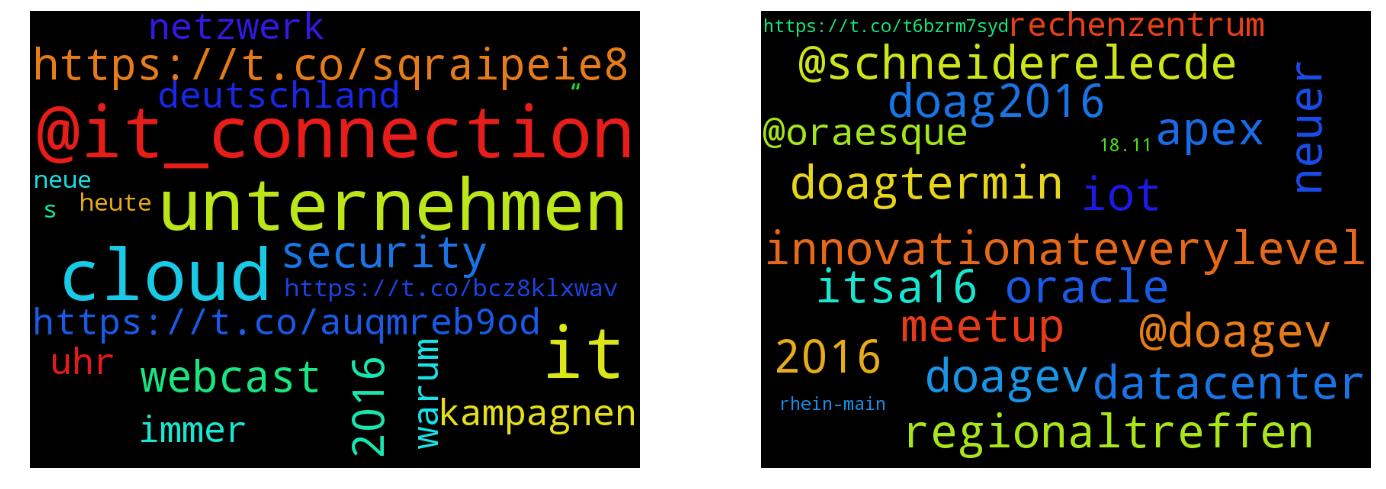

In [28]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'], [lda_models['target_1'][1], lda_models['target_2'][1]],
                           [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
    axes = [ax1, ax2]
    show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - German

Target 1 most important words:

Topic #0:
70.2: cloud
57.9: neue
54.4: java
53.6: jfn16
46.2: 4
43.1: itawards
43.0: oracle
40.9: @doagev
39.2: meetup
38.4: digitalisierung
37.8: forum
36.2: bigdata
36.0: 2016
36.0: nacht
35.7: online
35.3: 2
34.6: orclapex
34.1: nord
32.5: heute
31.1: newsletter

Topic #1:
52.4: “
43.5: „
42.3: danke
39.7: ja
39.0: 2016
38.8: @javaforumnord
35.0: schon
31.5: dank
29.1: @hamed_samad
26.6: ;-)
24.8: https
23.9: @ugugu
23.7: immer
23.2: itawards
23.1: ..
23.0: socialmedia
22.9: statt
22.4: folgen
22.4: freuen
21.2: @sql_williamd

Topic #2:
150.3: @msenterprisede
102.3: mscloudde
101.5: deutsche
98.7: https://t…
92.8: sicherheit
90.0: msft
88.8: setzt
86.2: made
86.2: germany
86.2: d-trust
86.2: sicherheitszertifikat
59.0: ab
58.3: mehr
51.4: danke
42.3: gibt
39.5: geht
35.8: kommt
33.2: @javaforumnord
30.6: https://t.c…
29.1: s

Target 2 most important words:

Topic #0:
52.2: @it_connection
38.0: it
26.5: security
22.1: unternehmen
18.2: webcast
14.6: de

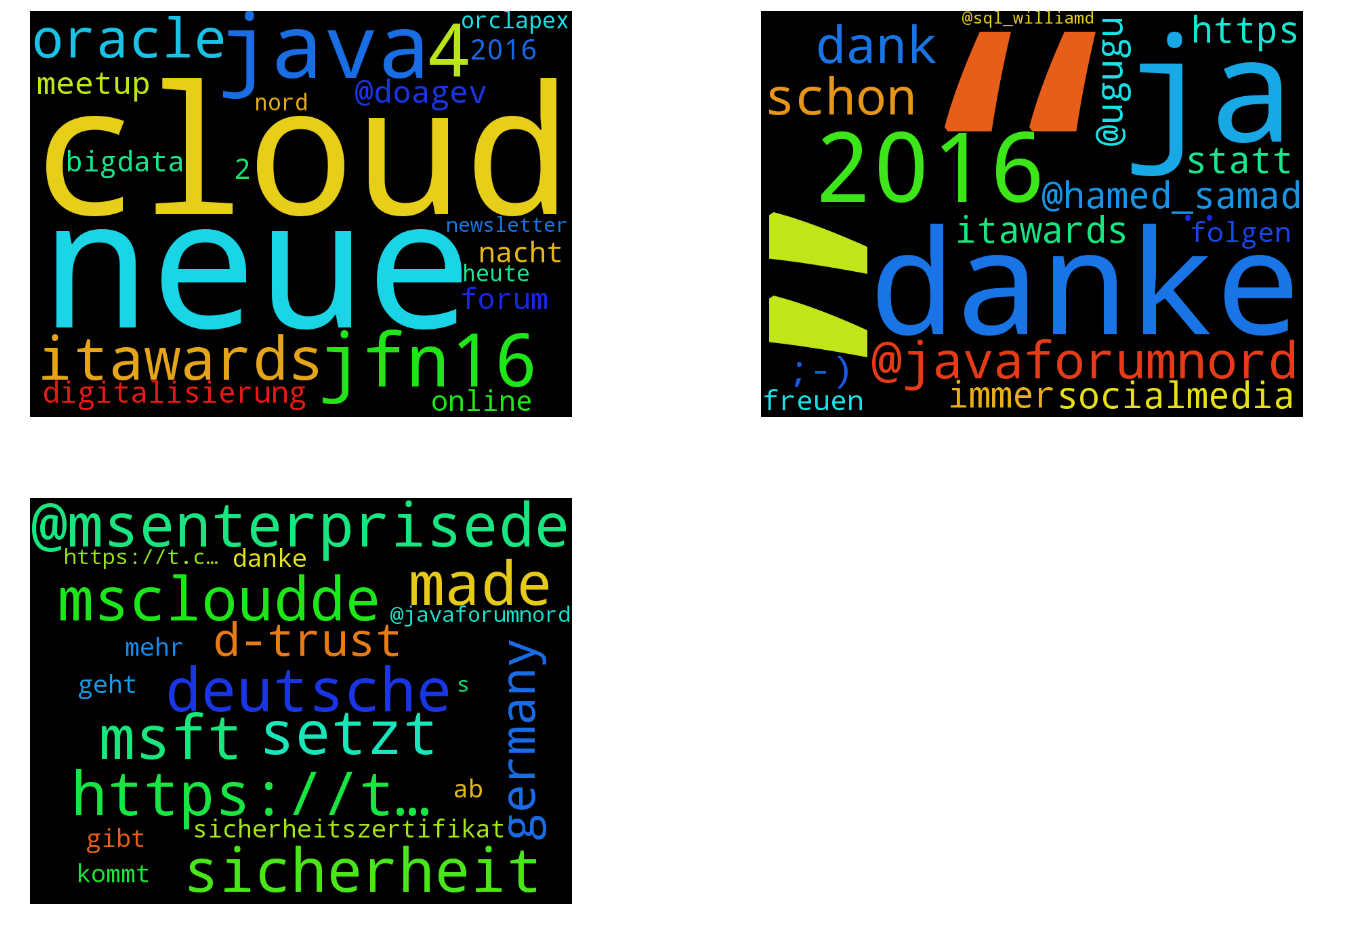

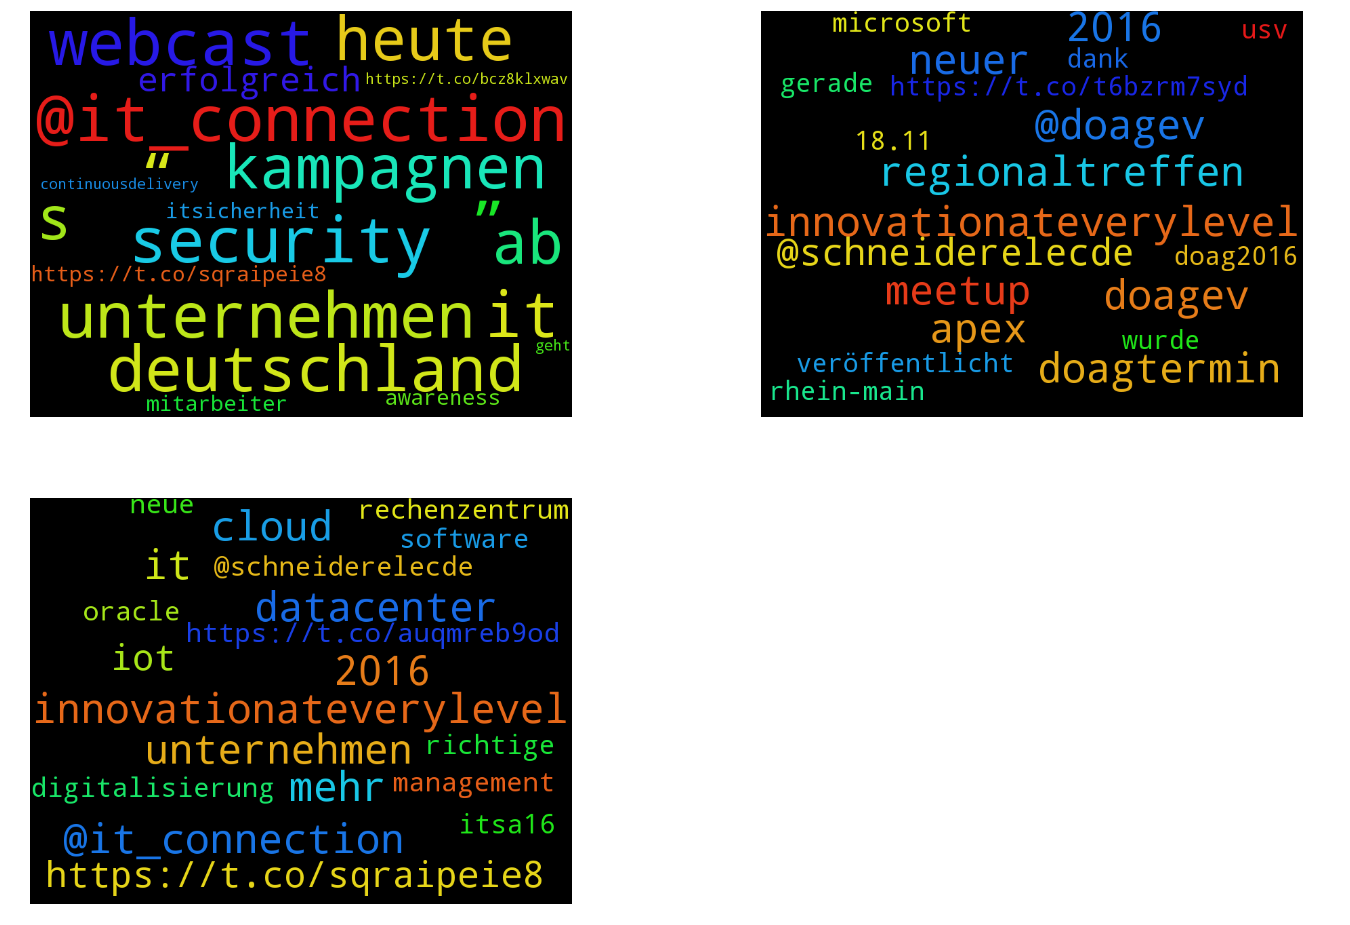

In [29]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'],
                                          [lda_models['target_1'][2], lda_models['target_2'][2]],
                                          [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
    axes = [ax1, ax2, ax3]
    show_word_clouds(model, axes, n_top_words)
    ax4.axis('off')

## Which words do often occur together?

In [30]:
vectorizer_1 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_1 = vectorizer_1.fit_transform(X_train_de_1)

co_occurrence_matrix_1 = word_matrix_1.T * word_matrix_1
co_occurrence_matrix_1.setdiag(0) 
array_1 = co_occurrence_matrix_1.toarray()
co_occurrences_1 = pd.DataFrame(array_1)

In [31]:
vectorizer_2 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_2 = vectorizer_2.fit_transform(X_train_de_2)

co_occurrence_matrix_2 = word_matrix_2.T * word_matrix_2
co_occurrence_matrix_2.setdiag(0) 
array_2 = co_occurrence_matrix_2.toarray()
co_occurrences_2 = pd.DataFrame(array_2)

In [32]:
vocab = vectorizer_1.get_feature_names()
co_occurrences_1['word'] = vocab
co_occurrences_1 = co_occurrences_1.set_index('word')
co_occurrences_1.columns = vocab

In [33]:
vocab = vectorizer_2.get_feature_names()
co_occurrences_2['word'] = vocab
co_occurrences_2 = co_occurrences_2.set_index('word')
co_occurrences_2.columns = vocab


Target: Target 1

Co-occurrences for: oracle
cloud               19
expertenseminar     13
@doagev             13
@martinberger_ch    12
anmelden             9
jet                  8
doag2016             8
webapps              7
berlin               7
„                    7
oraclecloudday       7
@appsassociatesd     7
Name: oracle, dtype: int64




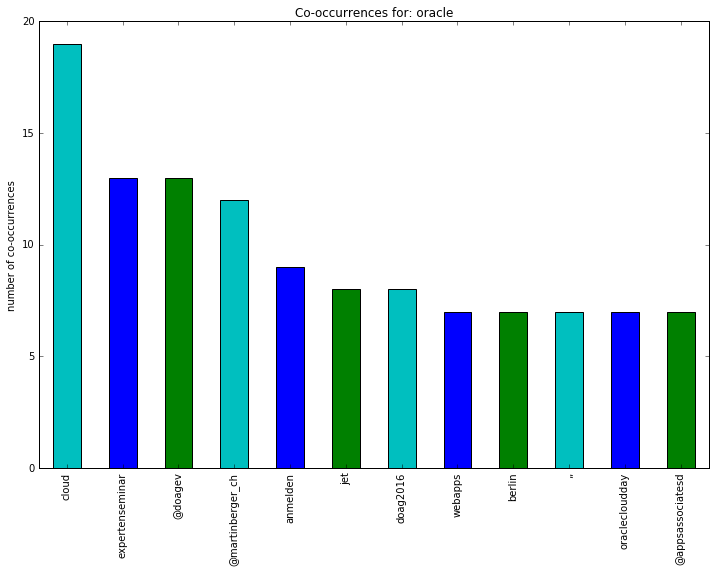


Target: Target 2

Co-occurrences for: oracle
cloud                      16
day                         9
https://t.co/pcr933niu7     7
it                          6
oraclecloudday              6
mobile                      6
payment                     5
wachstum                    5
12c                         5
2016                        5
twint                       5
mehr                        5
Name: oracle, dtype: int64




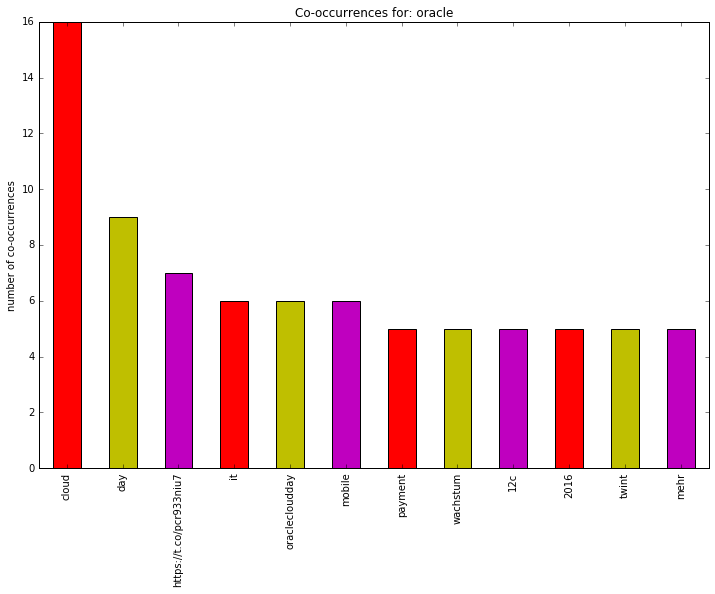


Target: Target 1

Co-occurrences for: microsoft
dpk16           8
@microsoftde    7
cloud           6
neue            5
surface         5
news            5
präsentiert     5
drehknopf       4
hardwar         4
aio             4
york            4
studio          4
Name: microsoft, dtype: int64




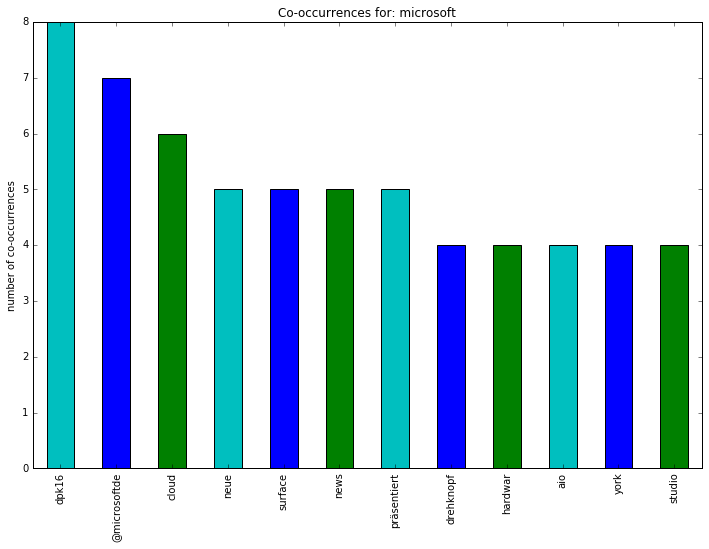


Target: Target 2

Co-occurrences for: microsoft
services                   4
azure                      4
nutzt                      3
bringt                     3
https://t.co/7udno67xjp    3
realität                   3
https://t.co/okm06ydwp3    3
iot-enabled                3
virtuelle                  3
innovationateverylevel     3
digital                    3
electric                   3
Name: microsoft, dtype: int64




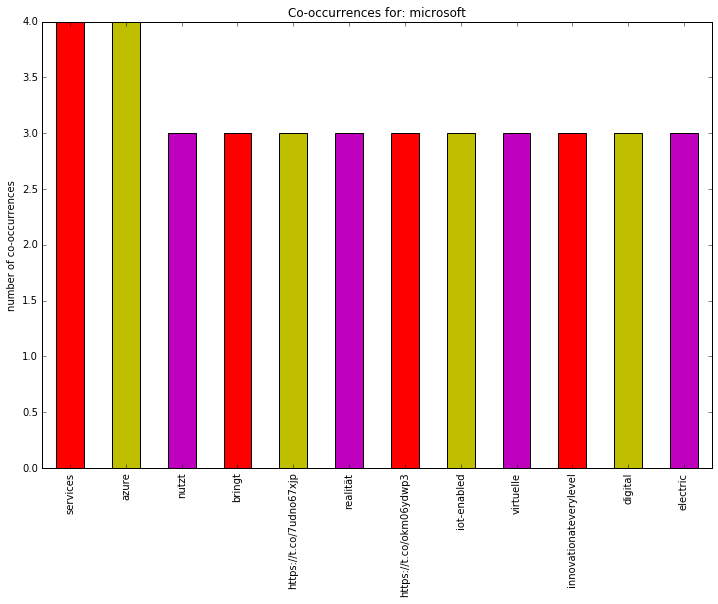


Target: Target 1

Co-occurrences for: iot
by                         6
@informatikaktue           5
https://t.co/khwmce9nfg    5
must-haves                 5
@andilehner                5
fünf                       5
user                       5
experience                 5
@oc_wire                   4
mehr                       3
internet                   3
profitieren                2
Name: iot, dtype: int64




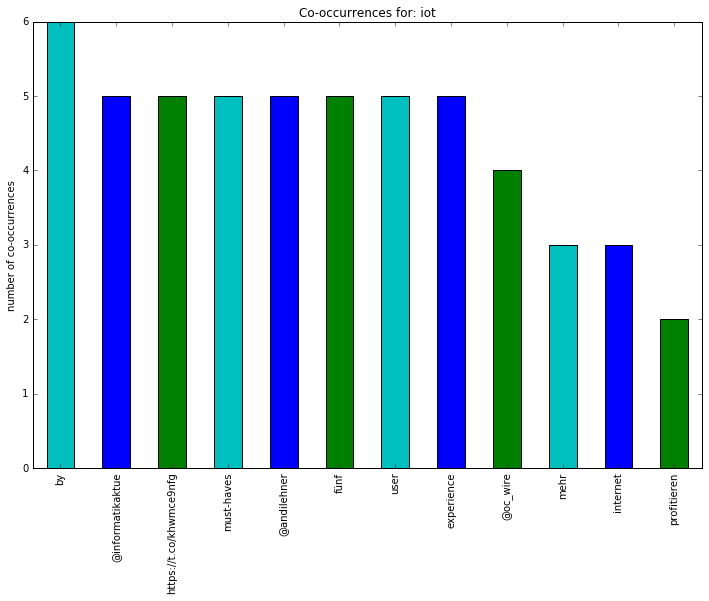


Target: Target 2

Co-occurrences for: iot
innovationateverylevel    10
iiot                       8
@schneiderelecde           7
lösungen                   5
eckpfeiler                 4
einführung                 4
m2m                        4
cybersecurity              4
paradigma                  4
neue                       4
industrie40                4
fastdata                   4
Name: iot, dtype: int64




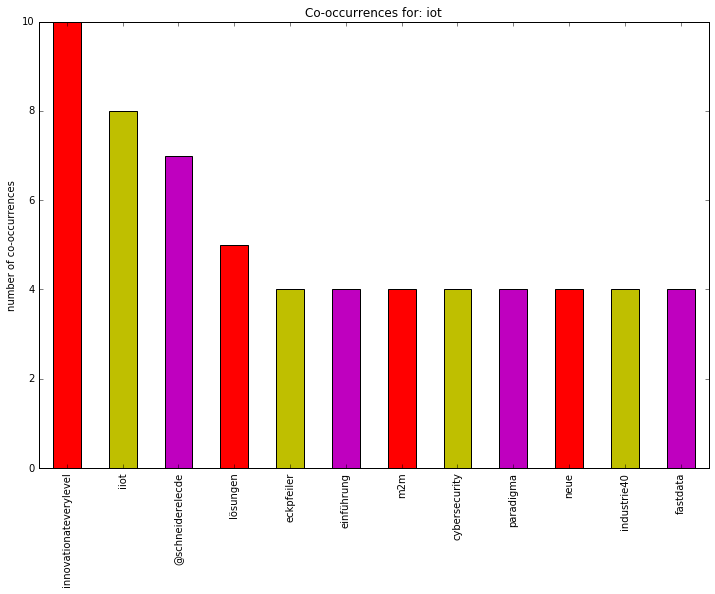


Target: Target 1

Co-occurrences for: bigdata
itawards            26
@bigdata_insider    21
sieger              12
@sas_dach            8
@talend              7
@sinequa             7
system               7
tools                7
management           7
heißen               7
infrastruktur        6
https://t.co/ss…     6
Name: bigdata, dtype: int64




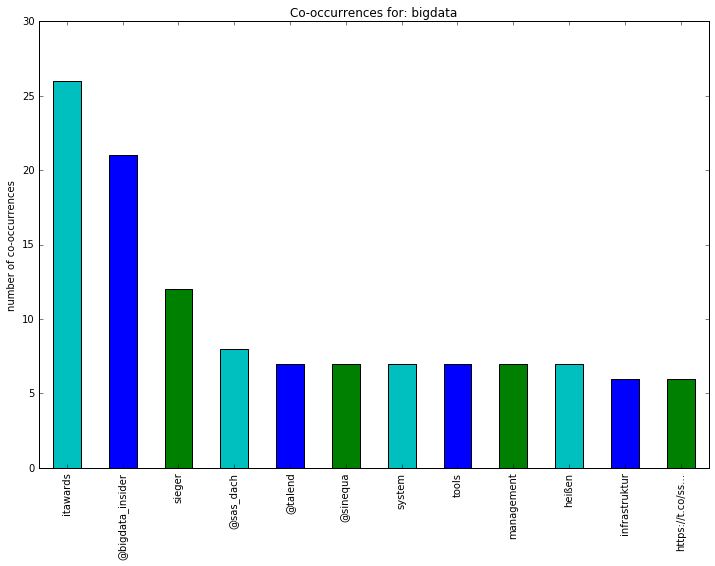


Target: Target 2

Co-occurrences for: bigdata
mobile                     3
facebook                   3
https://t.co/8qepkcovv4    3
cloud                      3
apps                       3
developer                  3
spannende                  3
it-themen                  3
@it_connection             2
infrastructure             1
sap                        1
apt-angriffe               1
Name: bigdata, dtype: int64




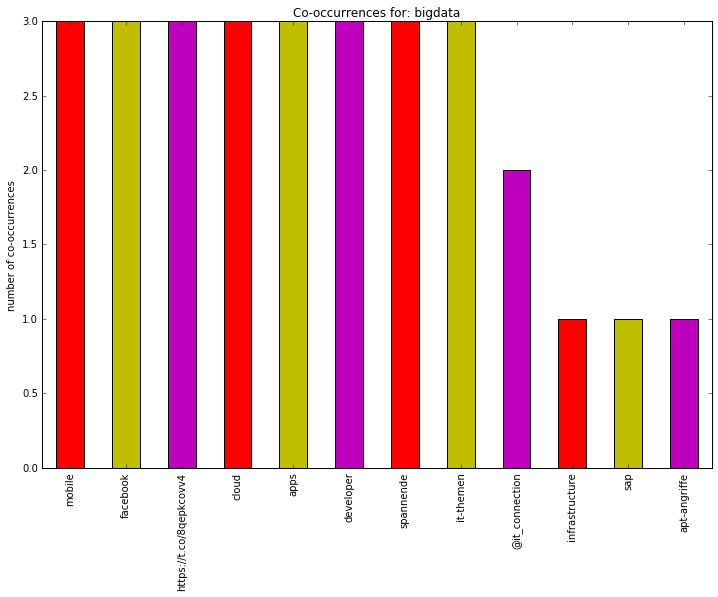


Target: Target 1

Co-occurrences for: cloud
oracle              19
itawards            18
@cloudinsiderde     16
oraclecloudday      13
@doagev             11
expertenseminar     10
swiss                9
@martinberger_ch     9
berlin               8
kategorie            8
hause                6
https                6
Name: cloud, dtype: int64




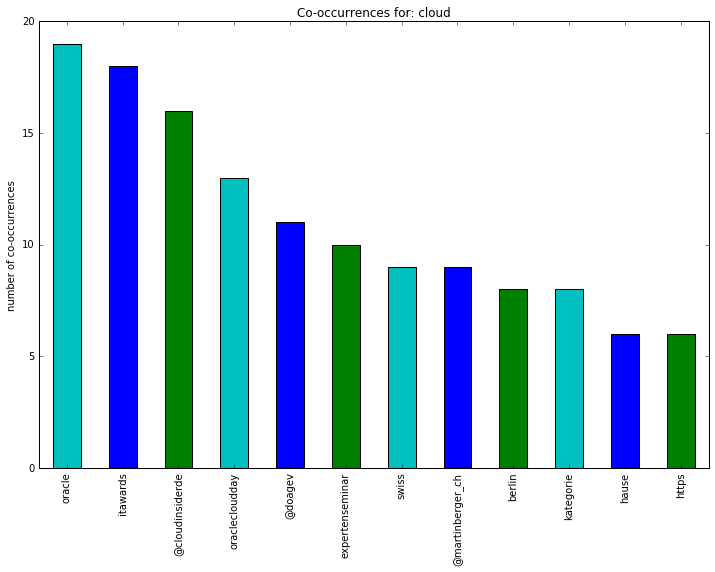


Target: Target 2

Co-occurrences for: cloud
oracle                     16
it                         12
day                         9
2016                        9
https://t.co/auqmreb9od     9
@it_connection              9
mobile                      8
strategie                   7
https://t.co/pcr933niu7     7
bereit                      7
finden                      7
oraclecloudday              7
Name: cloud, dtype: int64




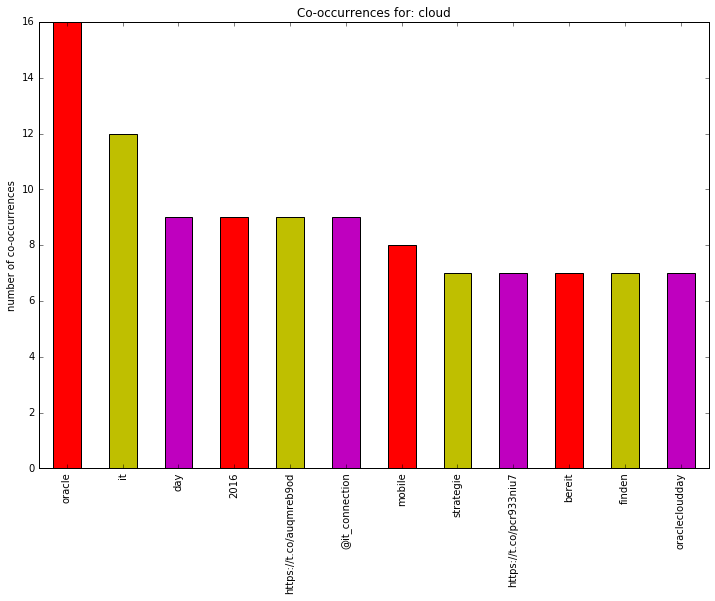

In [34]:
words = ['oracle', 'microsoft', 'iot', 'bigdata', 'cloud'] 
n = 12
for w in words: 
    for (target, co_occurrences, colors) in zip(['Target 1', 'Target 2'], [co_occurrences_1, co_occurrences_2], ['cbg', 'rym']):

        coocs = get_co_occurrences(co_occurrences, w, n)
        print('\nTarget: {}\n\nCo-occurrences for: {}\n{}\n\n'.format(target, w, coocs))
        plot_co_occurrences(w, coocs, colors)

# Tweets: French

In [35]:
stopwords_nltk = set(stopwords.words("french"))
stopwords_nltk
relevant_words = set([])

additional_stopwords = set(['les'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [36]:
tweets_french_1 = pd.read_csv(french_file_1, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

tweets_french_1['text_wo_#'] = tweets_french_1['text_processed'].apply(lambda x: remove_hash(x))
X_train_fr_1 = tweets_french_1['text_wo_#'].apply(lambda x: ' '.join(x))

In [37]:
tweets_french_2 = pd.read_csv(french_file_2, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

tweets_french_2['text_wo_#'] = tweets_french_2['text_processed'].apply(lambda x: remove_hash(x))
X_train_fr_2 = tweets_french_2['text_wo_#'].apply(lambda x: ' '.join(x))

In [38]:
X_train_fr_1[-10:]

80                               @vipmis Attending Odd in Vancouver orclapex vodd https://t.co/0k3YupjCra
81    La faille DirtyCOW impacte aussi Android et permet de rooter votre smartphone Un patch est à ven...
82                      Mise à jour pour iMovie en version 10.1 3 @ValerieAMaitre https://t.co/FjjGn77az7
83                                                                              @yoannpele nickel merci 😉
84                                                                                        @mp911de Touché
85                                                                                    @supaheld meeh Bier
86    Nous développons notre implantation en Suisse romande et recherchons un e Employé e de support d...
87    @FrankGeisler1 @SAP @SAPdach @sap_berater @NikolausKoepfer @ChNaegele @SvenTschenett @Eshaghi_A ...
88    @net4allch IoT et mots de passe par défaut Attention vos objets connectés pourraient bien servir...
89                                            

In [39]:
vectorizer_1 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_1 = vectorizer_1.fit_transform(X_train_fr_1)
feature_names_1 = vectorizer_1.get_feature_names()

In [40]:
vectorizer_2 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_2 = vectorizer_2.fit_transform(X_train_fr_2)
feature_names_2 = vectorizer_2.get_feature_names()

In [41]:
lda_models = {'target_1': [], 'target_2': []}

for word_matrix in [word_matrix_1, word_matrix_2]:
    for n_topics in range(1,4):    
        lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
        lda.fit(word_matrix)
        if id(word_matrix) == id(word_matrix_1):
            lda_models['target_1'].append(lda)
        else:
            lda_models['target_2'].append(lda)

## Most dominating topics - overall - French

Target 1 most important words:

Topic #0:
11.5: @oracle_france
9.8: welovestartups
8.3: oracledigital
8.2: rdv
8.2: @talendfr
7.5: @jpmichenaud
7.4: oracle
7.4: e
7.4: day
7.4: bigdata
7.4: suisse
6.6: @talend
5.8: nov
5.8: 8
5.0: 2016
5.0: sparksummit
5.0: direct
4.2: romande
4.2: start-ups
4.2: anime

Target 2 most important words:

Topic #0:
25.3: @proustnicolas
17.0: cloud
16.5: 2016
15.5: c'est
15.3: microsoft
13.8: it
13.7: dsi
13.7: forumphp
13.5: keynote
13.4: @alpict
13.0: métiers
12.9: @oracle_france
12.8: transformationdigitale
12.8: a
12.3: transformation
12.3: informatique
12.0: 1
11.2: comment
11.2: transfodigitale
11.0: @guss_france



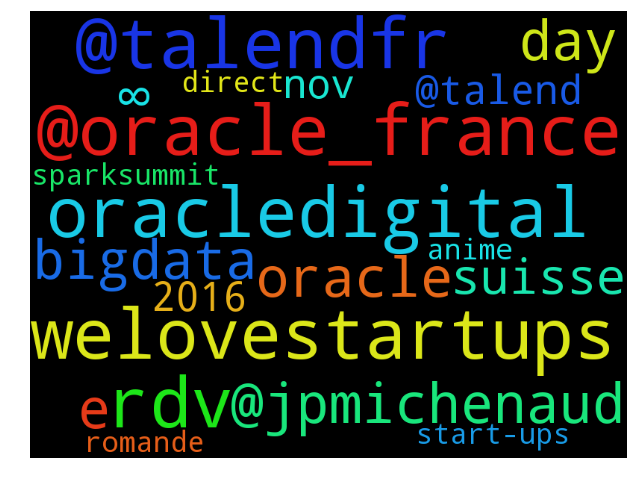

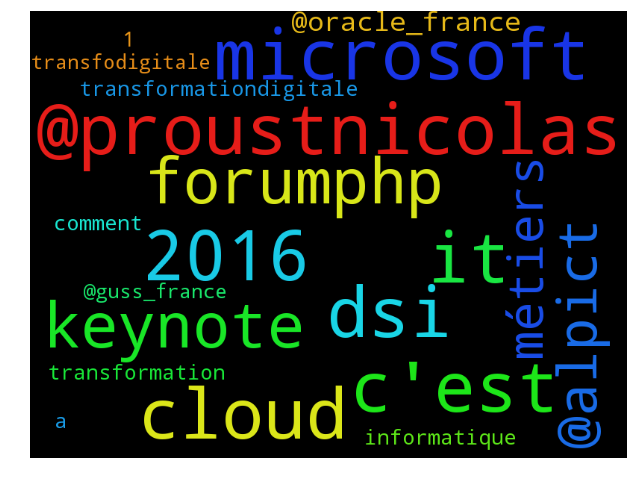

In [42]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'], [lda_models['target_1'][0], lda_models['target_2'][0]],
                           [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)
    fig, ax1 = plt.subplots(figsize = (12, 8))
    axes = [ax1]
    show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - French

Target 1 most important words:

Topic #0:
10.6: @oracle_france
9.0: welovestartups
6.7: day
6.3: @talendfr
6.2: @jpmichenaud
5.4: bigdata
4.7: @talend
4.6: 2016
4.6: sparksummit
3.8: ceo
3.8: anime
3.8: start-ups
3.8: retrouvez
3.8: table-ronde
3.7: digital
3.7: https://t.co/yyohfsispq
3.7: @frdigitale
3.7: @damiengromier
3.0: we
3.0: at

Topic #1:
7.0: e
6.4: suisse
5.9: rdv
5.6: oracledigital
5.0: oracle
4.6: direct
4.1: 8
4.1: nov
3.8: romande
3.8: a
3.0: by
3.0: blog
3.0: https://t.co/4jbuphyxsi
3.0: comment
3.0: applications
3.0: @strauch5
3.0: recherchons
3.0: employé
3.0: implantation
3.0: periscope

Target 2 most important words:

Topic #0:
13.1: 2016
12.4: @alpict
9.7: blockchain
8.7: a
8.6: comme
8.2: keynote
8.2: presse
8.1: transfodigitale
7.8: sorti
7.6: enquête
7.6: tablette
7.6: https://t.co/u8sev1dktg
7.5: merci
7.4: forumphp
6.9: unes
6.9: d'aujourd'hui
6.8: 2.11
6.7: gagner
6.7: faisons
6.7: point

Topic #1:
24.1: @proustnicolas
15.7: cloud
14.4: microsoft
13.2: dsi
1

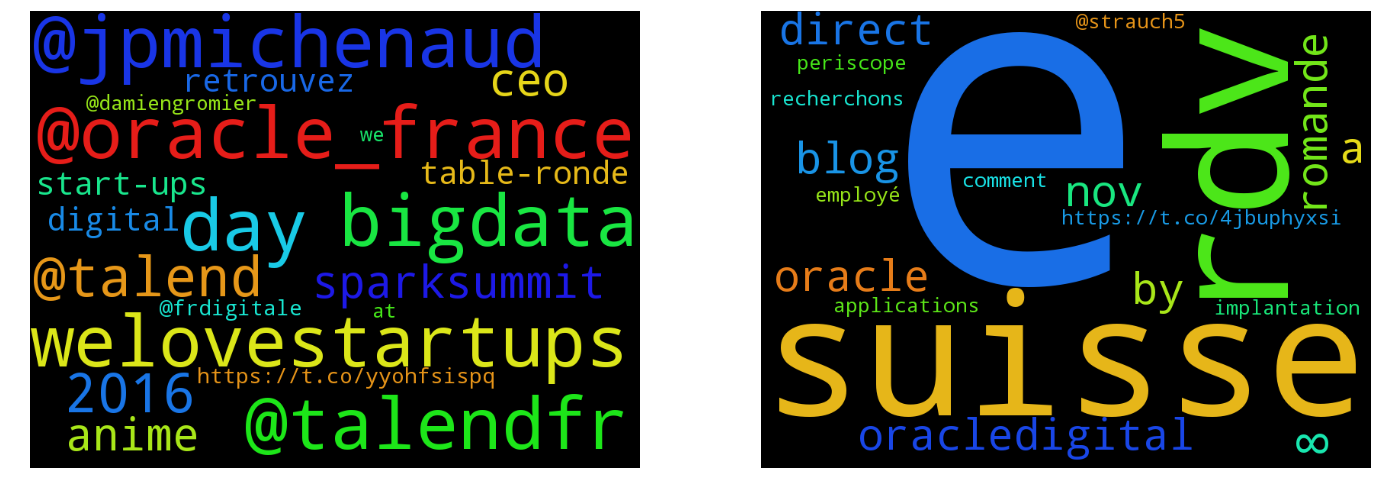

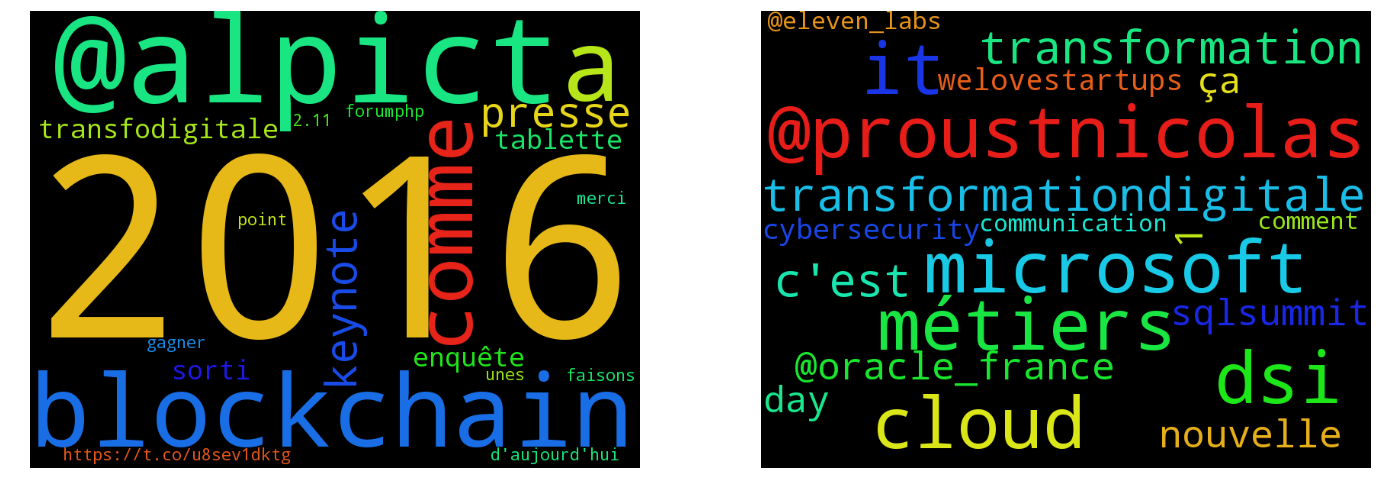

In [43]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'], [lda_models['target_1'][1], lda_models['target_2'][1]],
                           [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
    axes = [ax1, ax2]
    show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - French

Target 1 most important words:

Topic #0:
9.9: @oracle_france
9.1: welovestartups
6.7: day
6.1: @jpmichenaud
3.7: ceo
3.7: digital
3.6: start-ups
3.6: anime
3.6: table-ronde
3.6: @frdigitale
3.6: https://t.co/yyohfsispq
3.6: @damiengromier
2.9: we
2.9: at
2.9: gérard
2.9: oracledigital
2.9: sol
2.9: competitive
2.9: fournier
2.9: @appyreward

Topic #1:
5.5: rdv
5.3: oracledigital
4.7: oracle
4.5: direct
3.7: nov
3.7: 8
2.9: blog
2.9: suisse
2.9: https://t.co/4jbuphyxsi
2.9: @strauch5
2.9: periscope
2.9: recommendations
2.1: lead
2.1: formation
2.1: exécution
2.1: sql
2.1: hr
2.1: commande
2.1: by
2.1: 19

Topic #2:
6.9: e
6.4: bigdata
6.2: @talendfr
4.6: @talend
4.5: suisse
4.5: sparksummit
3.7: romande
2.9: applications
2.9: retrouvez
2.9: implantation
2.9: employé
2.9: recherchons
2.9: développons
2.9: genève
2.9: support
2.8: pratiques
2.8: 2016
2.1: https://t.co/iilqutcl8k
2.1: conquis
2.1: données

Target 2 most important words:

Topic #0:
12.1: @alpict
10.5: keynote
9.9: 2016
9.6

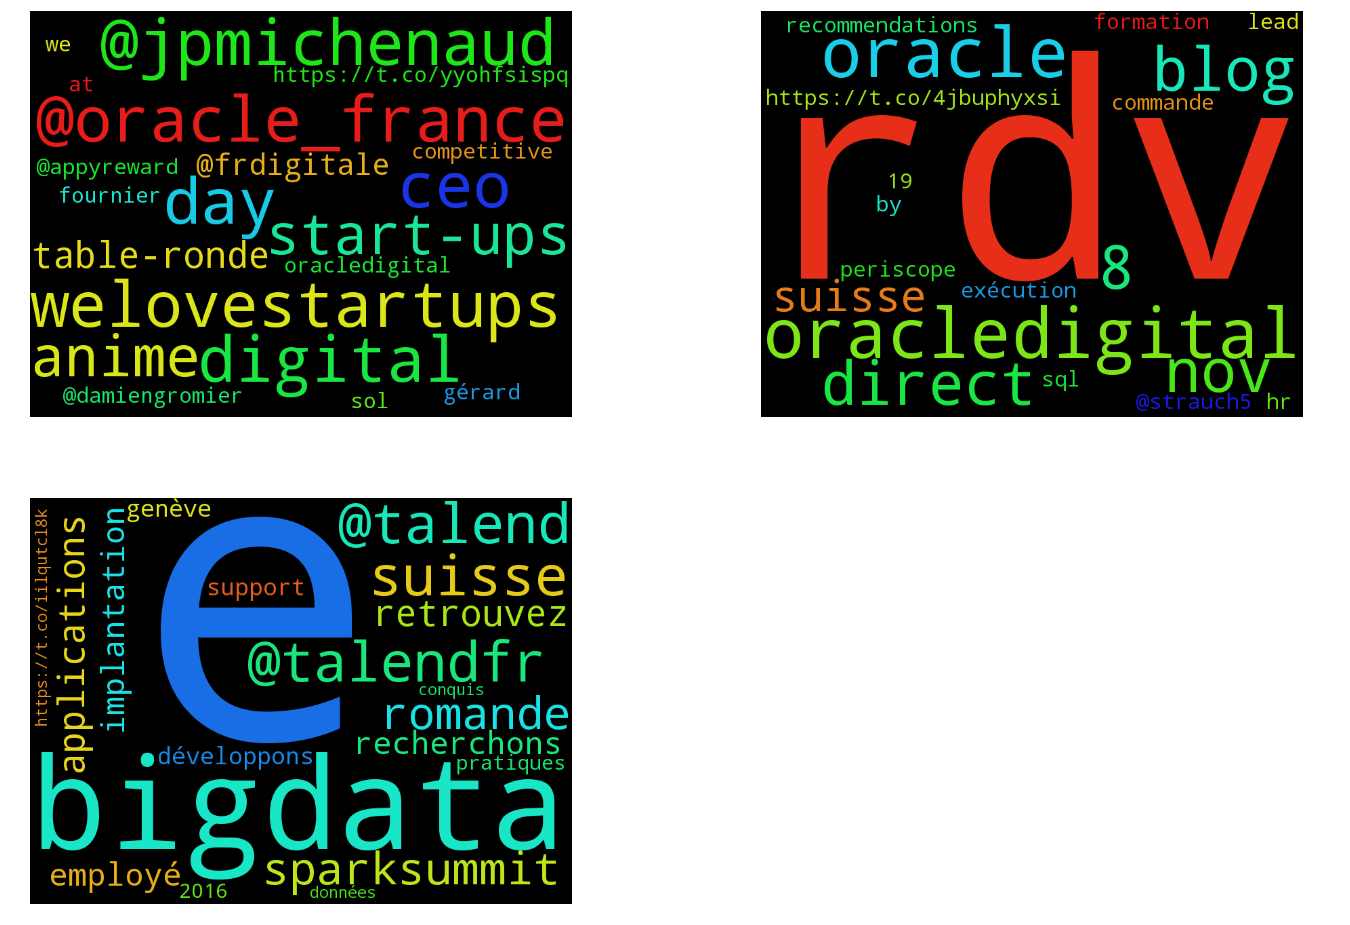

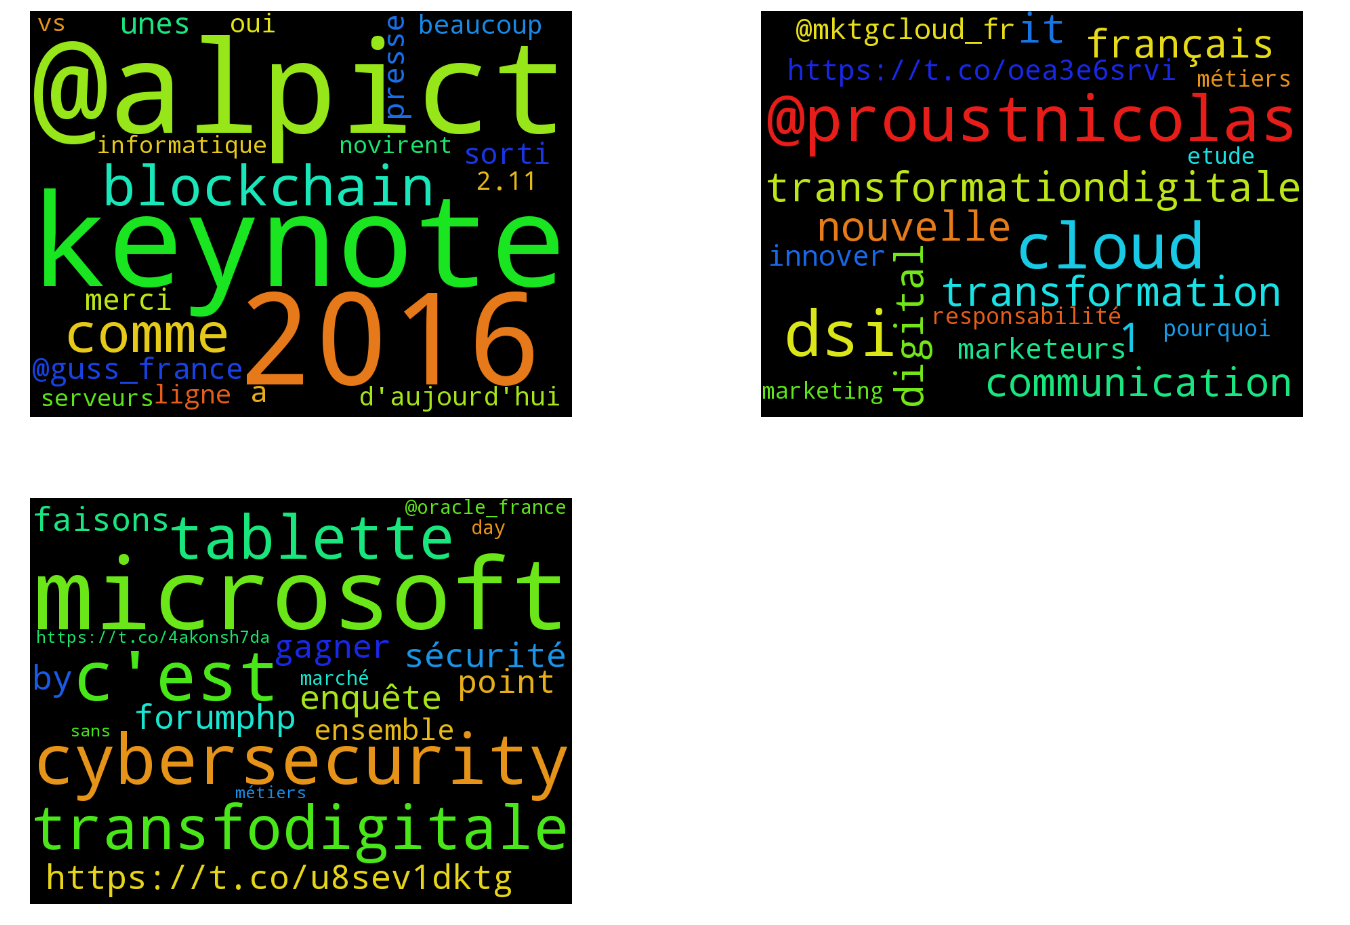

In [44]:
n_top_words = 20
for (target, model, feature_names) in zip(['Target 1', 'Target 2'],
                                          [lda_models['target_1'][2], lda_models['target_2'][2]],
                                          [feature_names_1, feature_names_2]):   
    print('{} most important words:\n'.format(target))
    print_top_words(model, n_top_words, feature_names)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
    axes = [ax1, ax2, ax3]
    show_word_clouds(model, axes, n_top_words)
    ax4.axis('off')

## Which words do often occur together?

In [45]:
vectorizer_1 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_1 = vectorizer_1.fit_transform(X_train_fr_1)

co_occurrence_matrix_1 = word_matrix_1.T * word_matrix_1
co_occurrence_matrix_1.setdiag(0) 
array_1 = co_occurrence_matrix_1.toarray()
co_occurrences_1 = pd.DataFrame(array_1)

In [46]:
vectorizer_2 = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
word_matrix_2 = vectorizer_2.fit_transform(X_train_fr_2)

co_occurrence_matrix_2 = word_matrix_2.T * word_matrix_2
co_occurrence_matrix_2.setdiag(0) 
array_2 = co_occurrence_matrix_2.toarray()
co_occurrences_2 = pd.DataFrame(array_2)

In [47]:
vocab = vectorizer_1.get_feature_names()
co_occurrences_1['word'] = vocab
co_occurrences_1 = co_occurrences_1.set_index('word')
co_occurrences_1.columns = vocab

In [48]:
vocab = vectorizer_2.get_feature_names()
co_occurrences_2['word'] = vocab
co_occurrences_2 = co_occurrences_2.set_index('word')
co_occurrences_2.columns = vocab


Target: Target 1

Co-occurrences for: oracle
blog               3
recommendations    3
@strauch5          3
formation          2
besoins            2
exécution          2
@oracle_france     2
introduction       2
by                 2
garantie           2
21                 2
welovestartups     2
Name: oracle, dtype: int64




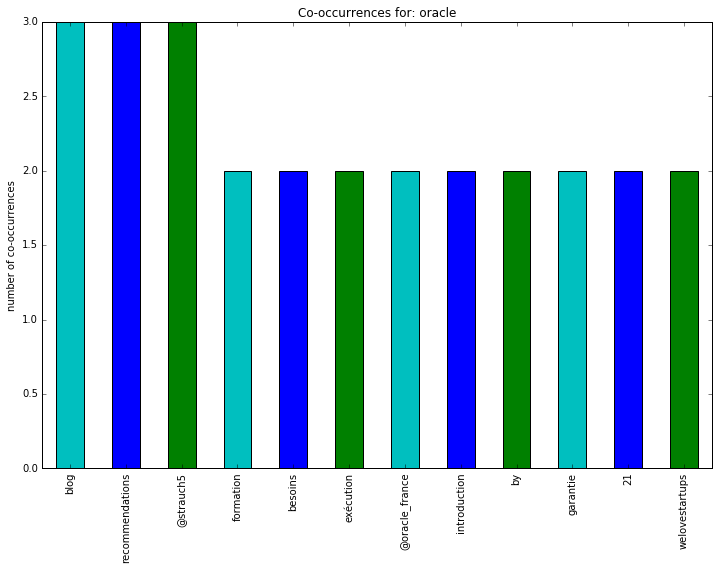


Target: Target 2

Co-occurrences for: oracle
and                        2
cloud                      2
pérez                      2
l'afpa                     2
nouvelle                   2
by                         2
joel                       2
informatique               2
monde                      2
@oracle_france             2
https://t.co/mksjjcowd3    2
tech                       2
Name: oracle, dtype: int64




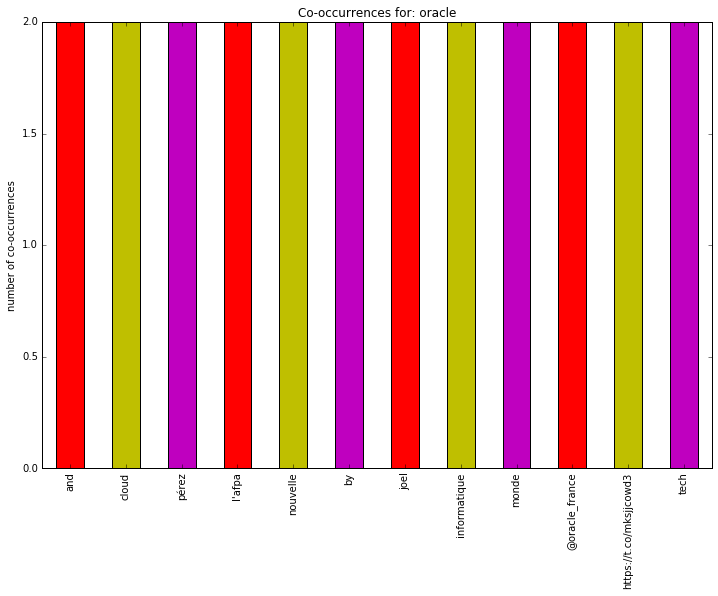


Target: Target 1

Co-occurrences for: iot
passe                      1
https://t.co/jbxpwhmrld    1
@po_st                     1
servir                     1
@net4allch                 1
entreprises                1
impact                     1
ddos                       1
https://t.co…              1
mots                       1
quel                       1
connectés                  1
Name: iot, dtype: int64




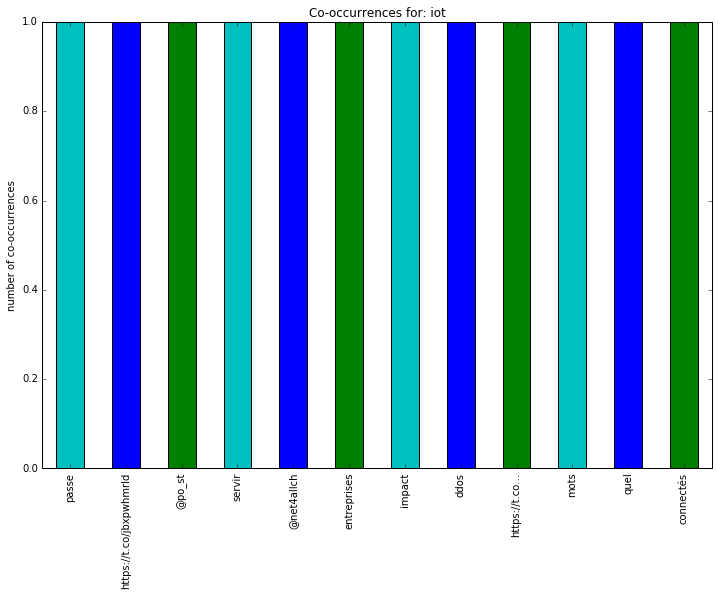


Target: Target 2

Co-occurrences for: iot
entreprises                3
objets                     2
quels                      2
https://t.co/ue5887swjx    2
connectés                  2
enjeux                     2
impact                     1
quel                       1
|                          1
https://t.co/jbxpwhmrld    1
frenchweb.fr               1
@po_st                     1
Name: iot, dtype: int64




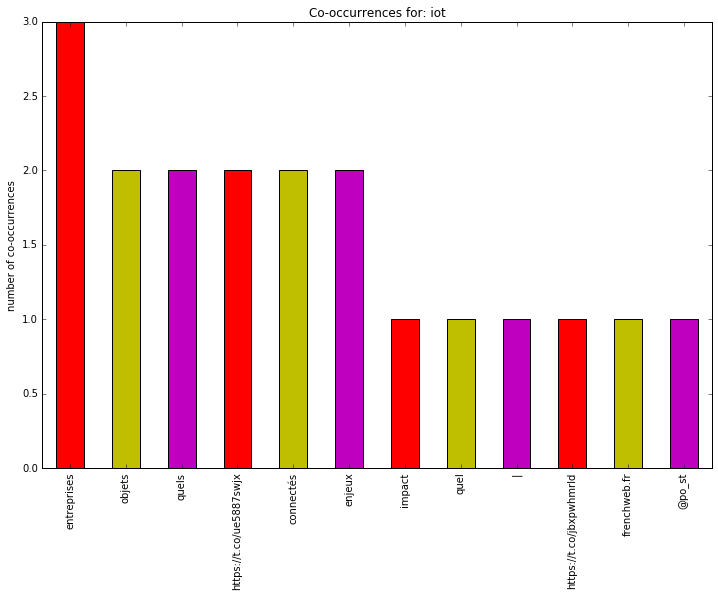


Target: Target 1

Co-occurrences for: bigdata
@talendfr                  8
@talend                    6
sparksummit                5
retrouvez                  3
bruxelles                  2
talendconnect              2
https://t.co/xgchiro17v    2
marché                     2
demain                     2
phares                     2
bonnes                     2
comment                    2
Name: bigdata, dtype: int64




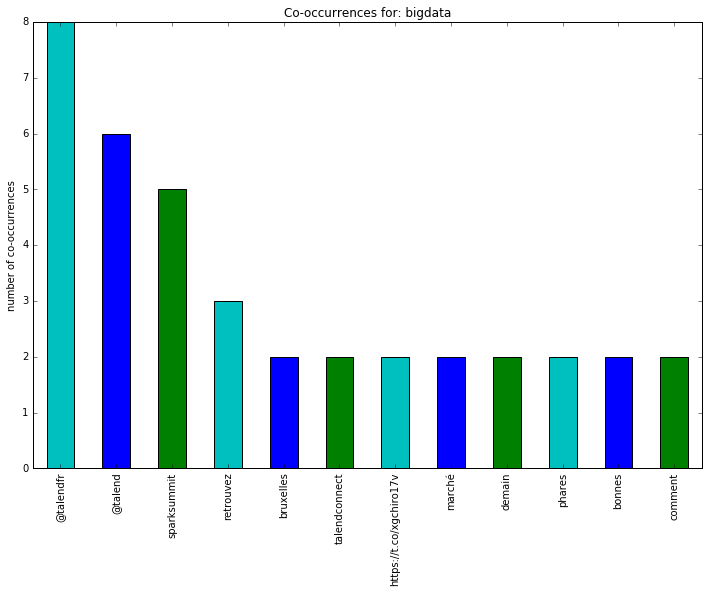


Target: Target 2

Co-occurrences for: bigdata
%                         3
cloud                     3
enregistrent              3
dsi                       3
français                  3
innovation                3
transformationdigitale    3
hausse                    3
budgets                   3
47                        3
dataops                   2
@proustnicolas            2
Name: bigdata, dtype: int64




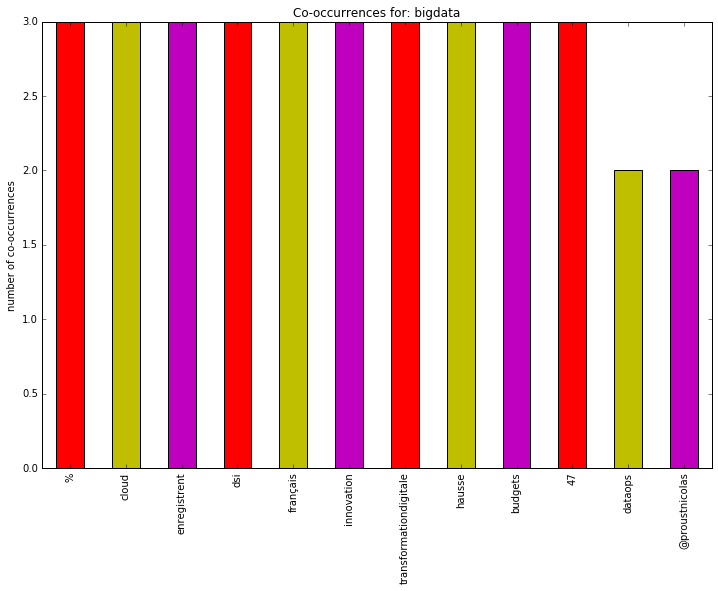


Target: Target 1

Co-occurrences for: cloud
oracledigital    3
rdv              3
nov              3
8                3
solutions        2
modernisez       2
grâce            2
entreprise       2
erp              2
@oracle          2
@oraclefinfr     2
prêtes           1
Name: cloud, dtype: int64




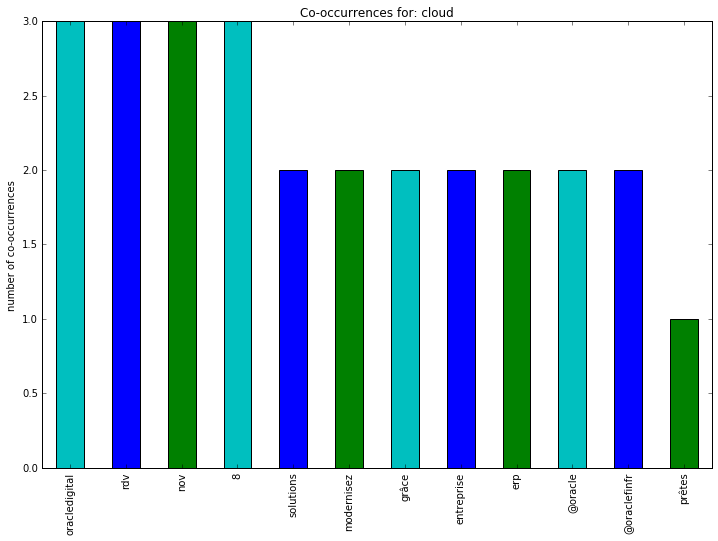


Target: Target 2

Co-occurrences for: cloud
dsi                        8
@proustnicolas             6
l'ignorance                5
pourquoi                   5
doit                       5
https://t.co/axg3iczrgy    5
@daviddariouch             5
être                       5
laissé                     5
hausse                     3
47                         3
budgets                    3
Name: cloud, dtype: int64




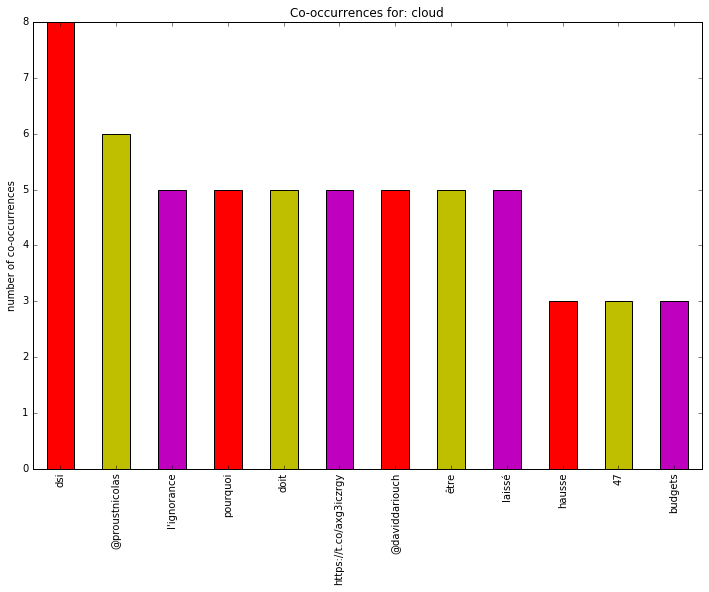

In [49]:
words = ['oracle', 'iot', 'bigdata', 'cloud'] 
n = 12
for w in words: 
    for (target, co_occurrences, colors) in zip(['Target 1', 'Target 2'], [co_occurrences_1, co_occurrences_2], ['cbg', 'rym']):

        coocs = get_co_occurrences(co_occurrences, w, n)
        print('\nTarget: {}\n\nCo-occurrences for: {}\n{}\n\n'.format(target, w, coocs))
        plot_co_occurrences(w, coocs, colors)